# Car Price prediction (Part II)

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

In [1]:
#!pip install -q tensorflow==2.3

In [2]:
#аугментации изображений
#!pip install albumentations -q

In [3]:
# Лемминизация текста
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# Загрузка библиотек

import os
import sys
import random
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.stats import weightstats
import PIL
import cv2
import re

import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from gensim.models import FastText

from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
import tensorflow.keras.layers as L
import keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

import matplotlib.pyplot as plt
import seaborn as sns
#from pylab import rcParams
#rcParams['figure.figsize'] = 10, 5
#%config InlineBackend.figure_format = 'svg' 
#%matplotlib inline

from tqdm.notebook import tqdm
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
# Фиксация random seed для воспроизводимости экспериментов
RS = 42

In [6]:
# Загрузка данных в переменные
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [8]:
# Целевая метрика
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [9]:
!pip freeze >= requirements.txt

# Первичный взгляд на данные

In [10]:
sample_submission.sample(3)

,sell_id,price
1198,1099858584,0
1414,1091754398,0
314,1095531026,0


In [11]:
pd.options.display.max_columns = train.shape[1]
display(train.head(3))
display(train.info())

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

None

In [12]:
pd.options.display.max_columns = test.shape[1]
display(test.head(3))
display(test.info())

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

None

### Расшифровка:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [13]:
# Функция возвращает визуализацию и относительную долю пропусков в данных
def na_values(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(df.isnull(),
                yticklabels=False, 
                cbar=False,
                cmap='viridis')
    plt.show()
    
    for column in df.columns:
        value = df[column].isna().sum()
        if value > 0:
            print(column.upper())
            print('%% пропущенных данных в столбце: \t{}'.format(np.round(value/len(df[column])*100), 2))
            print('(%% от общего кол-ва данных: \t{})'.format(np.round(value/np.product(df.shape)*100), 2))
            print()

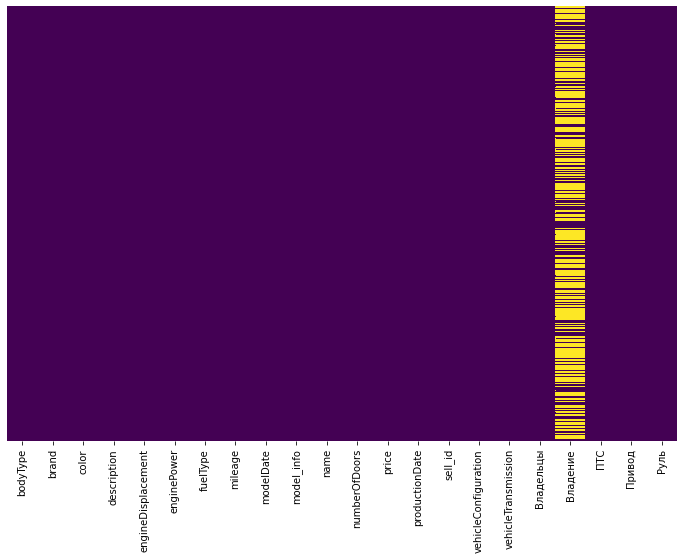

ВЛАДЕЛЬЦЫ
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)

ВЛАДЕНИЕ
%% пропущенных данных в столбце: 	65.0
(%% от общего кол-ва данных: 	3.0)



In [14]:
na_values(train)

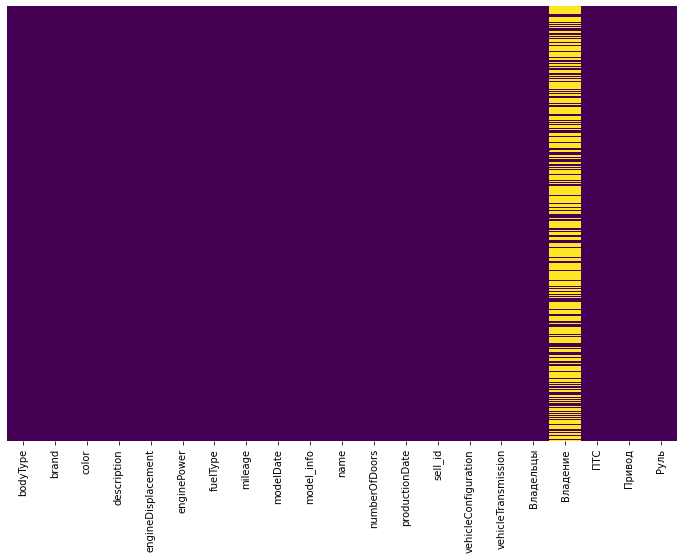

ВЛАДЕНИЕ
%% пропущенных данных в столбце: 	65.0
(%% от общего кол-ва данных: 	3.0)



In [15]:
na_values(test)

Тренировочная и тестовая выборки предоставлены в одинаковом формате. Доля пропусков по параметру "Владение" совпадают. Обработку признаков можно проводить совместно.

# Предобработка

In [16]:
# Объединение выборок
train['train'] = 1
test['train'] = 0
test['price'] = 0.0
data = pd.concat([train, test], ignore_index=True)
del train, test

pd.options.display.max_columns = data.shape[1]
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый,1
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый,1
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,коричневый,Продаётся любимица семьи. Автомобилем неактивн...,2.0 LTR,184 N12,бензин,76000,2011,3ER,320i 2.0 AT (184 л.с.),4,0.0,2012,1099414488,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,7 лет,Оригинал,задний,Левый,0
8349,внедорожник 5 дв.,BMW,синий,"В продаже автомобиль от компании АО ABTODOM, о...",3.0 LTR,218 N12,дизель,120381,2013,X5,25d 3.0d AT (218 л.с.) 4WD,5,0.0,2017,1099277058,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0
8350,внедорожник 5 дв.,AUDI,белый,Машина в идеальном техническом состоянии. Обсл...,1.4 LTR,150 N12,бензин,25790,2014,Q3,1.4 AMT (150 л.с.),5,0.0,2016,1098773964,ALLROAD_5_DOORS ROBOT 1.4,роботизированная,2 владельца,3 года и 3 месяца,Оригинал,передний,Левый,0
8351,седан,BMW,белый,Автомобиль приобретался новым у дилера Avilon ...,2.0 LTR,184 N12,бензин,104000,2009,5ER,520i 2.0 AT (184 л.с.),4,0.0,2013,1098835932,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,6 лет и 10 месяцев,Оригинал,задний,Левый,0


## Извлечение числовой данных

In [17]:
# Фунция возвращает время владения в месяцах
def get_own_time(string):
    months = 0
    if type(string) == str:
        numbers = re.findall(r'\d+', string)
        if len(numbers) == 2:
            months += int(numbers[0])*12 + int(numbers[1])
        else:
            if 'месяц' in string:
                months += int(numbers[0])
            else:
                months += int(numbers[0])*12
    return months

# Фунция возвращает время владения в месяцах
def get_eng_volume(string):
    try:
        return float('0'+string[:str.find(string,' ')])
    except:
        return None

In [18]:
# Извлечение информации из строк
data['eng_volume'] = data['engineDisplacement'].progress_apply(get_eng_volume)
data['eng_pwr'] = data['enginePower'].apply(lambda x: int(x[:str.find(x,' ')]))
data['own_time'] = data['Владение'].apply(get_own_time)
data.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train,eng_volume,eng_pwr,own_time
3867,седан,MERCEDES,белый,По заменам: \nОпоры двс и акпп;\nРолики и натя...,3.0 LTR,231 N12,бензин,145000,2006,C_KLASSE,300 3.0 AT (231 л.с.) 4WD,...,SEDAN AUTOMATIC 3.0,автоматическая,2 владельца,2 года и 7 месяцев,Оригинал,полный,Левый,1,3.0,231,31
3641,седан,MERCEDES,коричневый,Авто в отличном состоянии\nбез ДТП\nПробег как...,1.8 LTR,204 N12,бензин,167000,2011,C_KLASSE,250 1.8 AT (204 л.с.),...,SEDAN AUTOMATIC 1.8,автоматическая,3 или более,NaN,Оригинал,задний,Левый,1,1.8,204,0
4608,внедорожник 5 дв.,MERCEDES,чёрный,ЛОТ: 01210858\nVolvo Car Коптево\n\nЦену этого...,3.0 LTR,211 N12,дизель,278006,2006,GL_KLASSE,320 3.0d AT (211 л.с.) 4WD,...,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,1,3.0,211,0


In [19]:
# Проверка авто с неопределенным объемом двигателя
pd.options.display.max_columns = data.shape[1]
data[data.eng_volume.isna()==True]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,train,eng_volume,eng_pwr,own_time
2296,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184 N12,электро,9000,2017,I3,S Electro AT (136 кВт),5,2719000.0,2019,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,NaN,184,0
3725,хэтчбек 5 дв.,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",undefined LTR,170 N12,электро,39500,2017,I3,Electro AT (126 кВт),5,2299711.0,2017,1098041130,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый,1,NaN,170,35
3726,хэтчбек 5 дв.,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,undefined LTR,170 N12,электро,28800,2017,I3,Electro AT (126 кВт),5,2170000.0,2017,1100097316,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,NaN,170,0
5862,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170 N12,электро,35810,2013,I3,Electro AT (126 кВт),5,1690000.0,2016,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,NaN,170,0
6283,хэтчбек 5 дв.,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,undefined LTR,170 N12,электро,60000,2013,I3,Electro AT (126 кВт),5,1790000.0,2015,1097395090,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,NaN,170,0
7687,хэтчбек 5 дв.,BMW,серебристый,.,undefined LTR,170 N12,электро,89942,2013,I3,Electro AT (126 кВт),5,0.0,2014,1100166318,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,NaN,170,0


Объем двигателя не определен для электромобилей

In [20]:
# Удаление строковых данных
data.drop(['engineDisplacement', 'enginePower', 'name', 
           'vehicleConfiguration', 'Владение'], axis=1, inplace=True)
data.sample(3)

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,train,eng_volume,eng_pwr,own_time
1125,внедорожник 5 дв.,MERCEDES,чёрный,На машине установлен оригинальный обвес и тюни...,бензин,54194,2012,G_KLASSE_AMG,5,5200000.0,2014,1099495404,автоматическая,2 владельца,Оригинал,полный,Левый,1,5.5,544,73
8131,седан,AUDI,чёрный,"Автомобиль в отличном состоянии, колёса лето R...",бензин,111000,2009,A8,4,0.0,2012,1089609633,автоматическая,3 или более,Оригинал,полный,Левый,0,3.0,290,0
342,лифтбек,AUDI,чёрный,Автомобиль в отличном состоянии!\nВ максимальн...,бензин,140000,2010,A7,5,1290000.0,2012,1099787732,роботизированная,2 владельца,Оригинал,полный,Левый,1,3.0,300,0


In [21]:
# Предварительная разметка
bin_cols = []
cat_cols = []
dat_cols = []
num_cols = []

for column in data.columns:
    if len(data[column].unique()) == 2:
        bin_cols.append(column)
    elif data[column].dtype == 'datetime64[ns]':
        dat_cols.append(column)
    elif (data[column].dtype == float)|(data[column].dtype == int):
        num_cols.append(column)
    else:
        cat_cols.append(column)

print('Бинарные данные: \t', bin_cols)
print()
print('Категориальные данные: \t', cat_cols)
print()
print('Время/дата: \t\t', dat_cols)
print()
print('Числовые данные: \t', num_cols)

Бинарные данные: 	 ['ПТС', 'Руль', 'train']

Категориальные данные: 	 ['bodyType', 'brand', 'color', 'description', 'fuelType', 'model_info', 'vehicleTransmission', 'Владельцы', 'Привод']

Время/дата: 		 []

Числовые данные: 	 ['mileage', 'modelDate', 'numberOfDoors', 'price', 'productionDate', 'sell_id', 'eng_volume', 'eng_pwr', 'own_time']


In [22]:
# Метка тренировочной выборки не является бинарным признаком
bin_cols.remove('train')

# Текстовые переменные (description) будут обработаны отдельно
cat_cols.remove('description')

# Идентификатор(sell_id) не является параметром
num_cols.remove('sell_id')

# Наивная модель

In [23]:
def metrics(true, preds):
    output = []
    output.append(mape(true, preds))
    output.append(mean_absolute_error(true, preds))
    output.append(mean_squared_error(true, preds)**(1/2))
    return output

In [24]:
# Наивная модель
train, test = train_test_split(data[data.train==1], test_size=0.15, shuffle=True, random_state=RS)
preds = []
for index, row in pd.DataFrame(test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    preds.append(train.query(query)['price'].median())

# Заполним не найденные совпадения
preds = pd.DataFrame(preds)
preds = preds.fillna(preds.median())

# Округление
preds = (preds // 1000) * 1000

# Результат
pd.set_option('display.float_format', lambda x: '%.4f' % x)

results = pd.DataFrame({'naive': metrics(test['price'], preds[0].values)}, 
                       index = ['MAPE','MAE','RMSE'])
results

,naive
MAPE,0.1988
MAE,347328.2433
RMSE,932296.7579


# EDA

## Бинарные данные

In [25]:
# Функция, проверяющая наличие статистически значимых различий между вариациями признака
def get_stat_dif(df, col, target):
    variations=len(df[col].value_counts().index)
    indexes=[i for i in range (0,variations)]
    comb=list(combinations(indexes, 2))
    for c in comb:
        x = df[df[col] == df[col].value_counts().index[c[0]]][target]
        y = df[df[col] == df[col].value_counts().index[c[1]]][target]
        t_test = weightstats.ttest_ind(x, y, usevar='unequal')
        if t_test[1] <= 0.05/len(comb):
            return True
        else:
            return False

In [26]:
# Функция выводит основную информацию, визуализацию пропорций в тренировочной выборке и сравнение с тестовой
def sum_up_cat(df, col, target, label='train'):
    print(col.upper())
    train = df[df[label]==1]
    trn = train[col].value_counts(normalize=True)
    tst = df[df[label]==0][col].value_counts(normalize=True)
    vc = train[col].value_counts()
    changes = pd.DataFrame({'train':trn, 'test':tst})
    for i in vc.index:
        print('{} (%%):\t{}'.format(i, np.round(trn[i],2)))
        print('\t Среднее значение целевой:\t{}'.format(np.round(train[train[col] == i][target].mean(),2)))
    print('Cтатистически значимые различия:\t{}'.format(get_stat_dif(train, col, target)))
    fig, axs = plt.subplots(figsize=(15, 5), ncols=2)
    sns.barplot(x=vc.index, y=vc.values, palette='viridis', ax=axs[0])
    if len(train[col].unique())>5:
        axs[0].tick_params(labelrotation=45)
    sns.lineplot(data=changes, palette='viridis', linewidth=3, ax=axs[1])
    if len(changes.index)>5:
        axs[1].tick_params(labelrotation=45)
    plt.show()

ПТС
Оригинал (%%):	0.89
	 Среднее значение целевой:	1997735.95
Дубликат (%%):	0.11
	 Среднее значение целевой:	1079262.84
Cтатистически значимые различия:	True


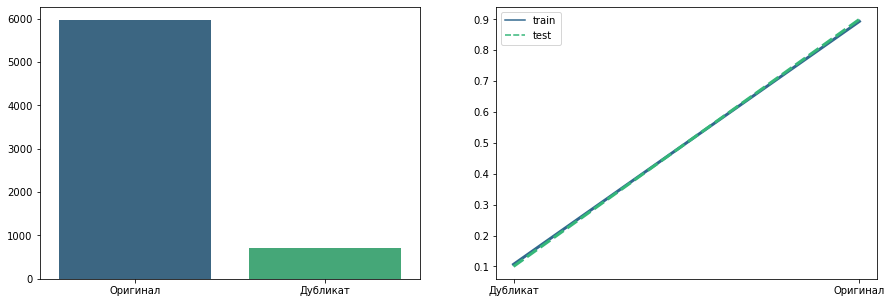

РУЛЬ
Левый (%%):	1.0
	 Среднее значение целевой:	1900145.02
Правый (%%):	0.0
	 Среднее значение целевой:	975000.0
Cтатистически значимые различия:	False


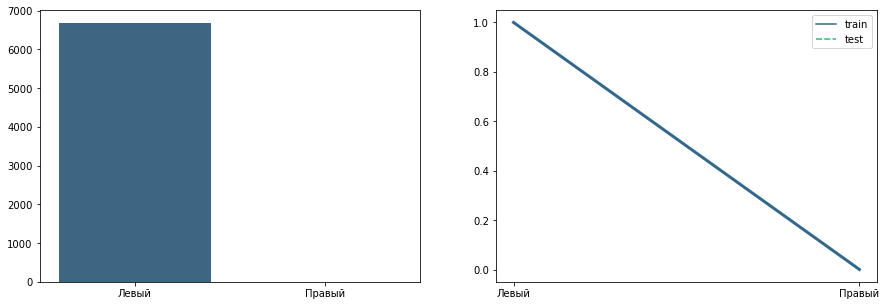

In [27]:
for column in bin_cols:
    sum_up_cat(data, column, 'price')

Доля авто с оригинальным ПТС схожи в тестовой и тренировочной выборках. Доля авто с правым рулем очень низка, статистически значимых различий не выявлено, стоит посмотреть, что это за авто.

In [28]:
data[data['Руль']=='Правый']

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,train,eng_volume,eng_pwr,own_time
1107,купе,AUDI,красный,"Эксклюзивное авто, собрано в Японии. Правый ру...",бензин,173160,2003,TT,2,450000.0000,2004,1098344588,автоматическая,3 или более,Дубликат,передний,Правый,1,1.8000,180,0
1517,компактвэн,BMW,синий,"Продам автомобиль, сборка Мюнхен, Бавария, экс...",дизель,43000,2015,2GRANDTOURER,5,1500000.0000,2016,1091158456,автоматическая,1 владелец,Оригинал,передний,Правый,1,2.0000,150,15


In [29]:
data.loc[1517]['description']

'Продам автомобиль, сборка Мюнхен, Бавария, экспортный вариант, люксовый вариант,  комплектация для этой модели максимальная. Произведена 15.12.2016, привезена из Японии в 2019г. . Оптимальный семейный автомобиль. . Причина продажи — для моей семьи маловат.'

Два немецкий авто, выпуженных для японского рынка есть только в тренировочной выборке, и могут искажать данные. Имеет смысл удалить данные исключения и избавиться от признака.

In [30]:
data = data[data['Руль']=='Левый']
data.drop('Руль', axis=1, inplace = True)
bin_cols.remove('Руль')
data.sample(3)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,train,eng_volume,eng_pwr,own_time
3587,седан,MERCEDES,синий,Для своих лет машина в идеальном состоянии ник...,бензин,400000,2005,S_KLASSE,4,550000.0000,2007,1096517934,автоматическая,2 владельца,Оригинал,полный,1,4.7000,340,0
1710,хэтчбек 5 дв.,BMW,красный,Машина в хорошем состоянии. Торг у капота,бензин,110000,2007,1ER,5,350000.0000,2008,1098292752,автоматическая,3 или более,Дубликат,задний,1,1.6000,115,23
542,седан,MERCEDES,серый,"Комплектация edition 1, без дтп, идеальное сос...",бензин,26000,2016,E_KLASSE_AMG,4,6500000.0000,2017,1100129854,автоматическая,1 владелец,Оригинал,полный,1,4.0000,612,38


## Категориальные данные

### Переменные, с малым кол-вом уникальных значений

BRAND
BMW (%%):	0.42
	 Среднее значение целевой:	1718815.57
MERCEDES (%%):	0.34
	 Среднее значение целевой:	2580641.74
AUDI (%%):	0.24
	 Среднее значение целевой:	1234777.34
Cтатистически значимые различия:	True


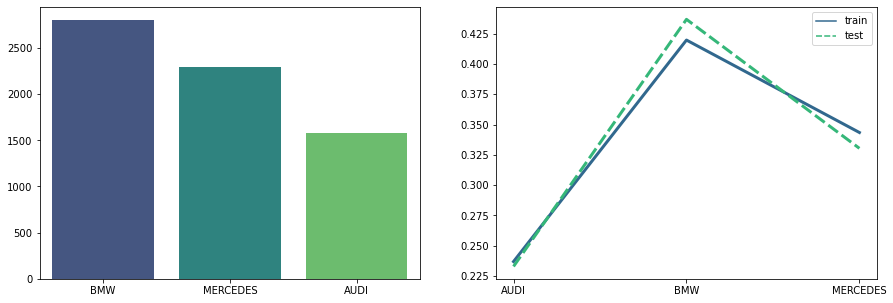

FUELTYPE
бензин (%%):	0.72
	 Среднее значение целевой:	1736177.32
дизель (%%):	0.28
	 Среднее значение целевой:	2318411.5
гибрид (%%):	0.0
	 Среднее значение целевой:	2599583.33
электро (%%):	0.0
	 Среднее значение целевой:	2133742.2
Cтатистически значимые различия:	True


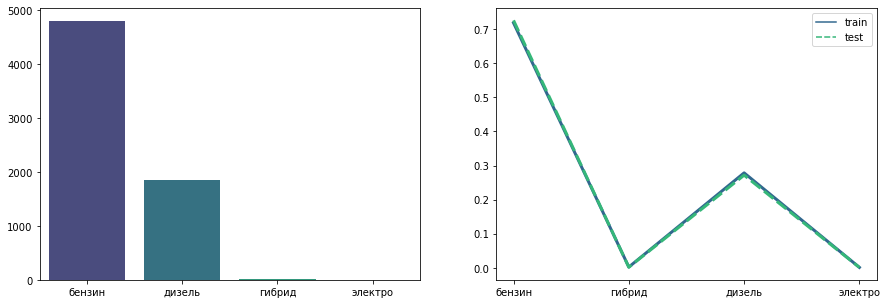

VEHICLETRANSMISSION
автоматическая (%%):	0.79
	 Среднее значение целевой:	2047206.35
роботизированная (%%):	0.14
	 Среднее значение целевой:	1647541.07
вариатор (%%):	0.05
	 Среднее значение целевой:	679936.38
механическая (%%):	0.02
	 Среднее значение целевой:	917805.67
Cтатистически значимые различия:	True


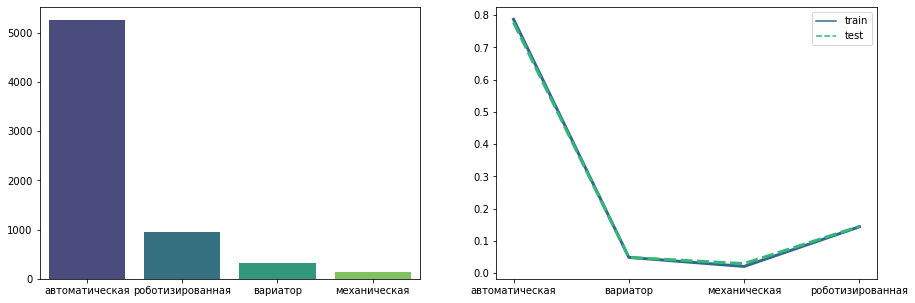

ВЛАДЕЛЬЦЫ
3 или более (%%):	0.4
	 Среднее значение целевой:	1172793.29
1 владелец (%%):	0.3
	 Среднее значение целевой:	2921471.76
2 владельца (%%):	0.3
	 Среднее значение целевой:	1827310.95
Cтатистически значимые различия:	True


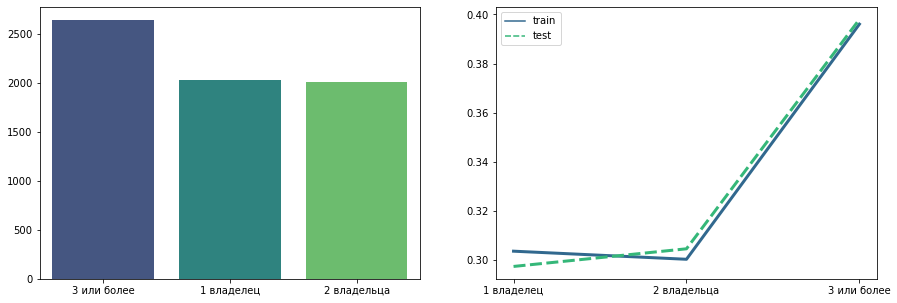

ПРИВОД
полный (%%):	0.63
	 Среднее значение целевой:	2291359.28
задний (%%):	0.27
	 Среднее значение целевой:	1373554.29
передний (%%):	0.1
	 Среднее значение целевой:	906993.66
Cтатистически значимые различия:	True


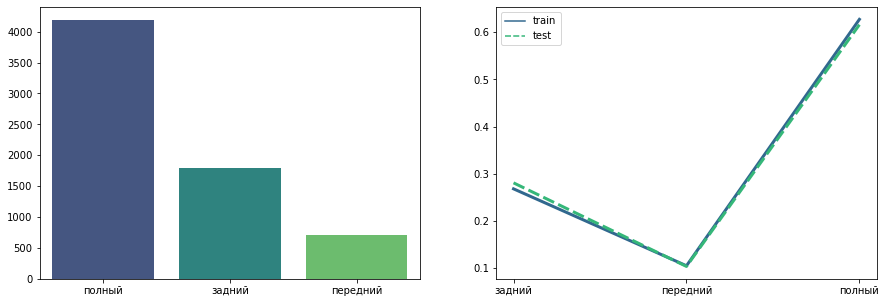

In [31]:
# Переменные, для которых уникальных значений меньше 15ти.
for column in cat_cols:
    if len(data[column].unique())<=15:
        sum_up_cat(data, column, 'price')

Для данных переменных найдены статистически значимые различия.

В тестовой выборке чуть выше доля авто бренда BMW и имееещих двух владельцев.

Необходимо также рассмотреть авто с пропущенным параметром "Владельцы", которые присутствуют только в тренировочной выборке.

In [32]:
data[data['Владельцы'].isna()==True]

,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,train,eng_volume,eng_pwr,own_time
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,бензин,160000,1999,S8,4,600000.0000,2001,1019330519,автоматическая,NaN,Оригинал,полный,1,4.2000,360,127


Имеется только один автомобиль с пропущенным полем "Владельцы". Пропуск можно заполнить наиболее популярным значением для автомобилей со схожими параметрами.

In [33]:
data[(data.brand=='AUDI')&(data.modelDate==1999)]['Владельцы'].value_counts()

3 или более    7
2 владельца    1
1 владелец     1
Name: Владельцы, dtype: int64

Вероятность того, что автомобиль марки AUDI 1999 года выпуска имеет 3 или более владельца довольно высока.

In [34]:
data.loc[4994]['Владельцы'] = data[(data.brand=='AUDI')&(data.modelDate==1999)]['Владельцы'].value_counts().index[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Переменные, с большим кол-вом уникальных значений

In [35]:
# Проверка наличия статистически значимых различий для переменных с большим числом уникальных значений
for column in cat_cols:
    if len(data[column].unique())>15:
        print(column.upper())
        print('Cтатистически значимые различия:\t{}'.format(get_stat_dif(data[data.train==1], column, 'price')))

BODYTYPE
Cтатистически значимые различия:	True
COLOR
Cтатистически значимые различия:	True
MODEL_INFO
Cтатистически значимые различия:	True


Для данных переменных найдены статистически значимые различия.

# Числовые данные

In [36]:
# Функция рассчитывает кол-во выбросов по столбцам и их долю
def outbursts(df, col):
    Q25 = df[col].quantile(0.25)
    Q75 = df[col].quantile(0.75)
    IQR = Q75 - Q25
    lowest = Q25 - 1.5*IQR
    highest = Q75 + 1.5*IQR
    amount = df[(df[col] < lowest)|(df[col] > highest)].count()[0]
    ratio = amount/df.shape[0]
    return amount, ratio, lowest, highest

In [37]:
# Функция выводит основную информацию и график признака
def sum_up_num(df, col, target, label='train'):
    print(col.upper())
    train = df[df[label]==1]
    trn = train[col].describe()[1:]
    tst = df[df[label]==0][col].describe()[1:]
    changes = pd.DataFrame({'train':trn, 'test':tst})
    
    print(trn)
    print('Кол-во выбросов: {} \t (%%: {})'.format(outbursts(train, col)[0], 
                                                   np.round(outbursts(train, col)[1]*100,2)))
    print()
    fig, axs = plt.subplots(figsize=(20, 5), ncols=3)
    sns.distplot(train[col], kde=True, ax=axs[0])
    sns.boxplot(data = train,  x = col, palette = 'viridis', ax=axs[1])
    sns.lineplot(data=changes, palette='viridis', linewidth=3, ax=axs[2])
    plt.show()

MILEAGE
mean   120526.3362
std     81458.5740
min         1.0000
25%     59255.7500
50%    111000.0000
75%    168000.0000
max    999999.0000
Name: mileage, dtype: float64
Кол-во выбросов: 113 	 (%%: 1.69)



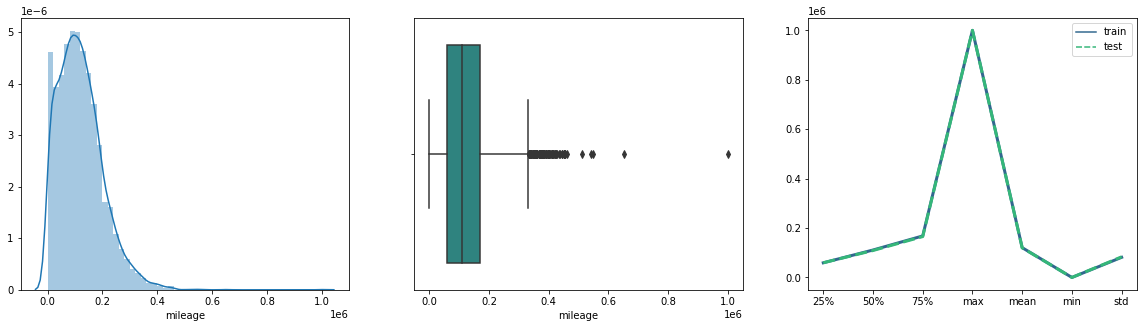

MODELDATE
mean   2010.1359
std       5.3707
min    1975.0000
25%    2007.0000
50%    2011.0000
75%    2014.0000
max    2019.0000
Name: modelDate, dtype: float64
Кол-во выбросов: 143 	 (%%: 2.14)



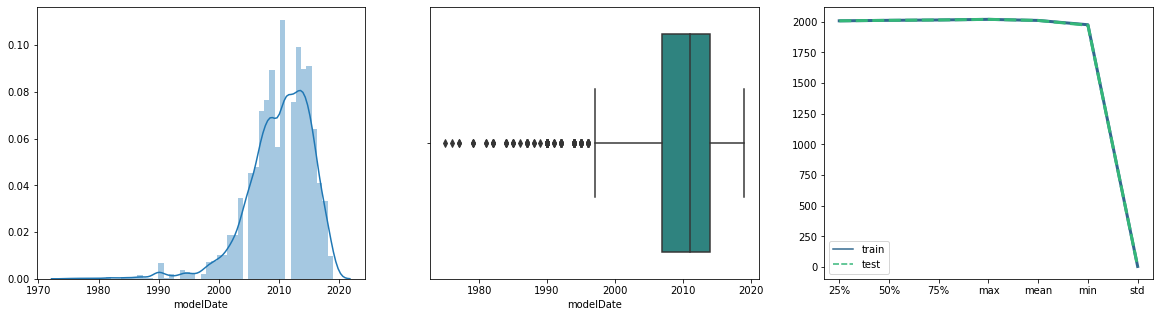

NUMBEROFDOORS
mean   4.2687
std    0.8783
min    2.0000
25%    4.0000
50%    4.0000
75%    5.0000
max    5.0000
Name: numberOfDoors, dtype: float64
Кол-во выбросов: 626 	 (%%: 9.37)



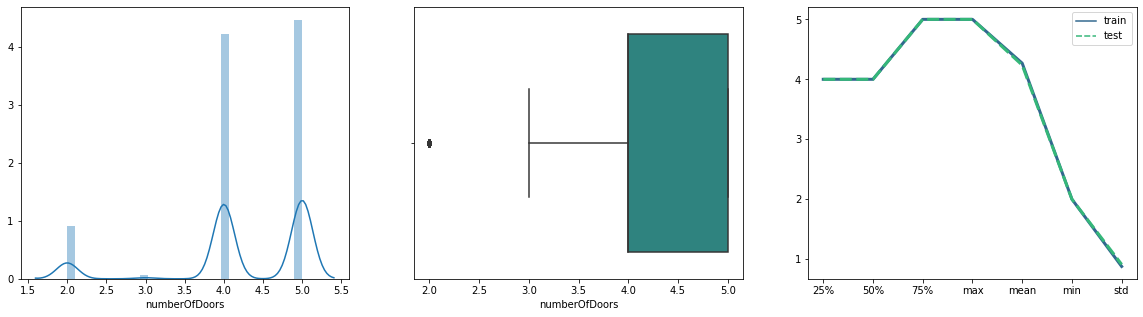

PRICE
mean    1900145.0247
std     1914351.2138
min      301301.0000
25%      800000.0000
50%     1300000.0000
75%     2299783.2500
max    23900000.0000
Name: price, dtype: float64
Кол-во выбросов: 448 	 (%%: 6.71)



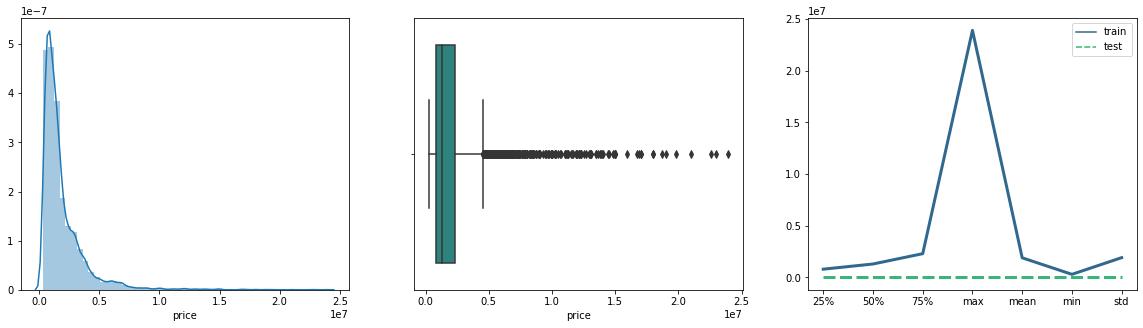

PRODUCTIONDATE
mean   2012.0322
std       5.0492
min    1982.0000
25%    2009.0000
50%    2013.0000
75%    2016.0000
max    2020.0000
Name: productionDate, dtype: float64
Кол-во выбросов: 106 	 (%%: 1.59)



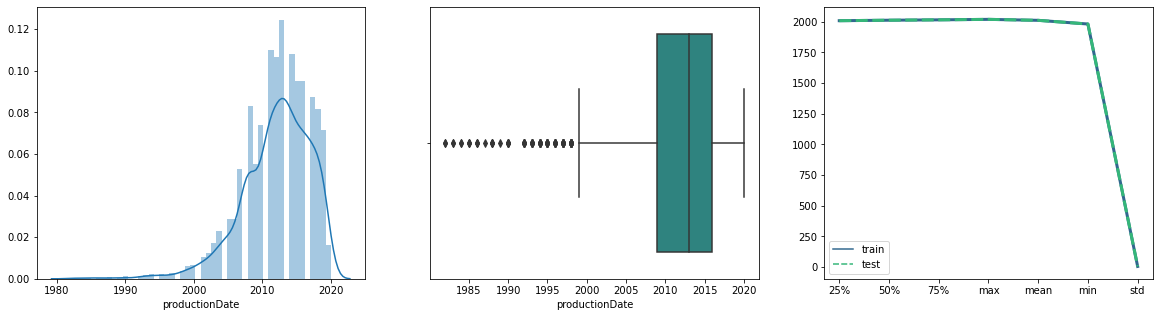

ENG_VOLUME
mean   2.7845
std    1.0615
min    0.7000
25%    2.0000
50%    2.8000
75%    3.0000
max    6.6000
Name: eng_volume, dtype: float64
Кол-во выбросов: 565 	 (%%: 8.46)



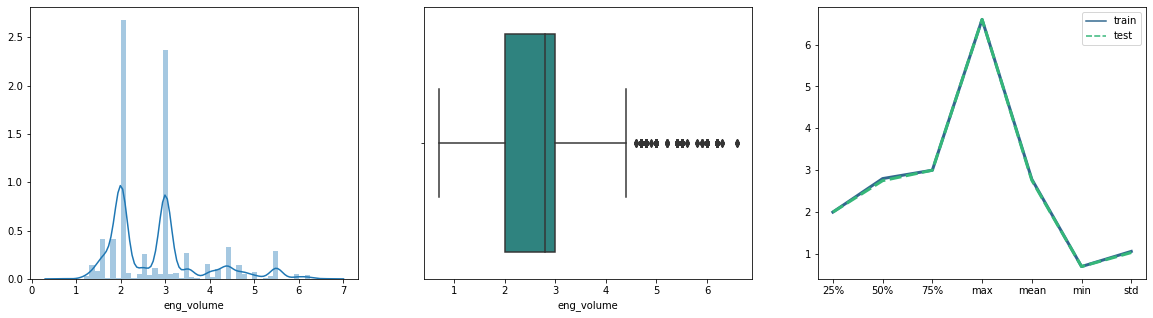

ENG_PWR
mean   255.8159
std    109.2449
min     75.0000
25%    184.0000
50%    231.0000
75%    306.0000
max    639.0000
Name: eng_pwr, dtype: float64
Кол-во выбросов: 402 	 (%%: 6.02)



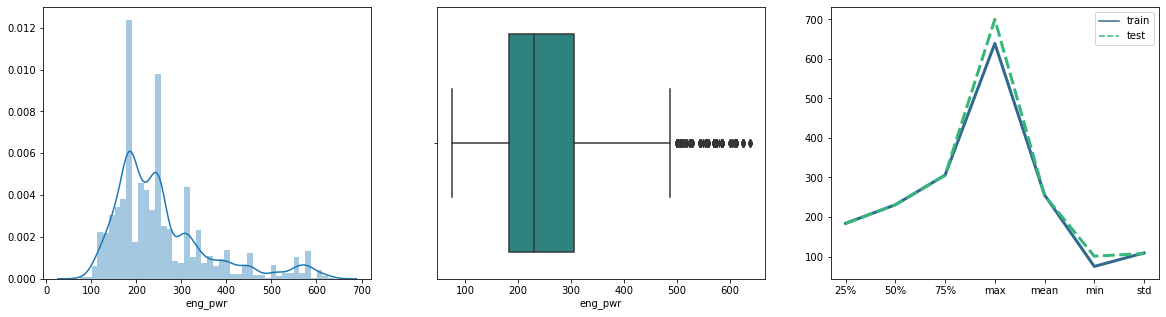

OWN_TIME
mean    16.8451
std     31.4902
min      0.0000
25%      0.0000
50%      0.0000
75%     22.0000
max    334.0000
Name: own_time, dtype: float64
Кол-во выбросов: 792 	 (%%: 11.86)



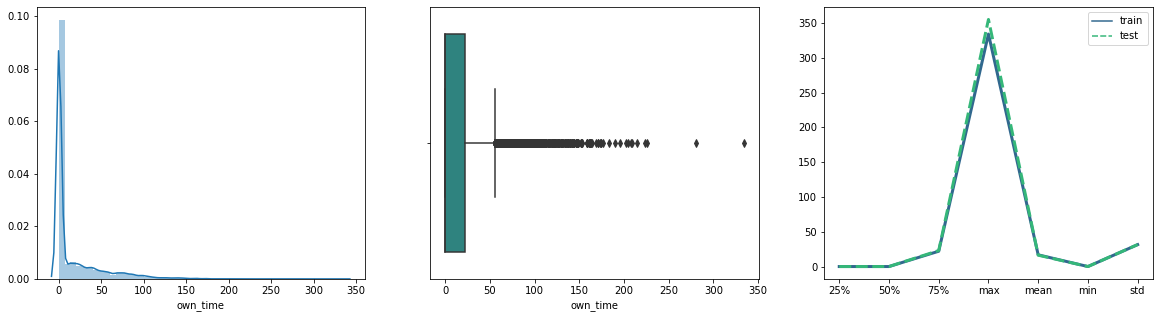

In [38]:
for column in num_cols:
    sum_up_num(data, column, 'price')

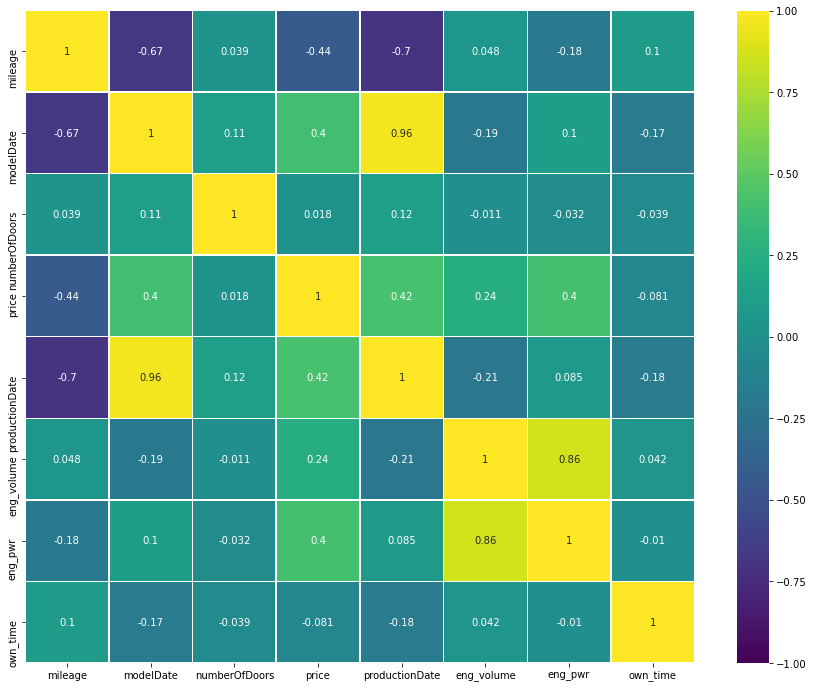

In [39]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data[num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Признак "numberOfDoors" имеет 4 уникальных значения и может быть рассмотрен как категориальный.

Признаки "modelDate" и "prductionDate" можно привести к лог-нормальному распределению путем вычета из текущщего года (2021). Ожидаемо, данные два признака высокоскоррелированы между собой.

В дальнейшем, для работы с нейросетями, имеет смысл привести признаки к нормальному распределению путем логорифмирования.

NUMBEROFDOORS
5 (%%):	0.46
	 Среднее значение целевой:	2087705.33
4 (%%):	0.44
	 Среднее значение целевой:	1640509.42
2 (%%):	0.09
	 Среднее значение целевой:	2274014.31
3 (%%):	0.01
	 Среднее значение целевой:	602499.98
Cтатистически значимые различия:	True


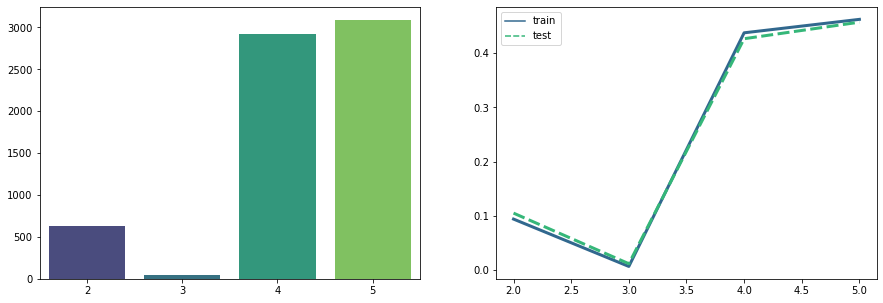

In [40]:
# Перенос numberOfDoors в категориальные переменные
num_cols.remove('numberOfDoors')
cat_cols.append('numberOfDoors')
sum_up_cat(data, 'numberOfDoors', 'price')

"numberOfDoors" не имеет выраженной линейной зависимости с целевой переменной и может быть рассмотрен как категориальный признак. Доли авто каждого класса схожи между тестовой и тренировочной выборками.

In [41]:
# Привод "modelDate" и "prductionDate" к лог-нормальному распределению
for col in ['modelDate', 'productionDate']:
    data[col] = 2021 - data[col]
    
data.sample(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,bodyType,brand,color,description,fuelType,mileage,modelDate,model_info,numberOfDoors,price,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,train,eng_volume,eng_pwr,own_time
789,внедорожник 5 дв.,MERCEDES,чёрный,"Автомобиль уникальный, таких в России нет и не...",бензин,18000,4,GLA_CLASS_AMG,5,2839000.0000,3,1097404639,роботизированная,1 владелец,Оригинал,полный,1,2.0000,381,22
4963,внедорожник 5 дв.,AUDI,серый,«Inchcape Certified- Первый международный офи...,бензин,38330,4,Q5,5,2680000.0000,4,1099888398,роботизированная,2 владельца,Оригинал,полный,1,2.0000,249,0
538,седан,BMW,чёрный,Один владелец. Пробег реальный. \nКуплена в ко...,дизель,102500,10,3ER,4,1300000.0000,8,1094984788,автоматическая,1 владелец,Оригинал,полный,1,2.0000,184,0


# Базовый CatBoost

Тестирование CatBoost на логорифмированной целевой переменной.

In [42]:
# Функция возвращает визуализацию результатов
def plot_results(results, target_metric):
    MMS = MinMaxScaler()
    trans_res = results.T
    scaled_res = pd.DataFrame(MMS.fit_transform(trans_res), 
                              columns=trans_res.columns, index=trans_res.index)
    
    fig, axs = plt.subplots(figsize=(15, 7), gridspec_kw={'height_ratios': [5, 1]}, nrows=2)
    sns.lineplot(x=results.columns, y=results.loc[target_metric].values, 
                 marker='o', sort = False, ax=axs[0])
    axs[0].set(ylabel=target_metric, xlabel='ITER')
    sns.lineplot(data = scaled_res, marker='o', 
                          sort = False, palette='viridis', ax=axs[1])
    plt.legend(loc='upper left')
    axs[1].set(ylabel='All Metrics', xlabel='ITER')
    plt.show()

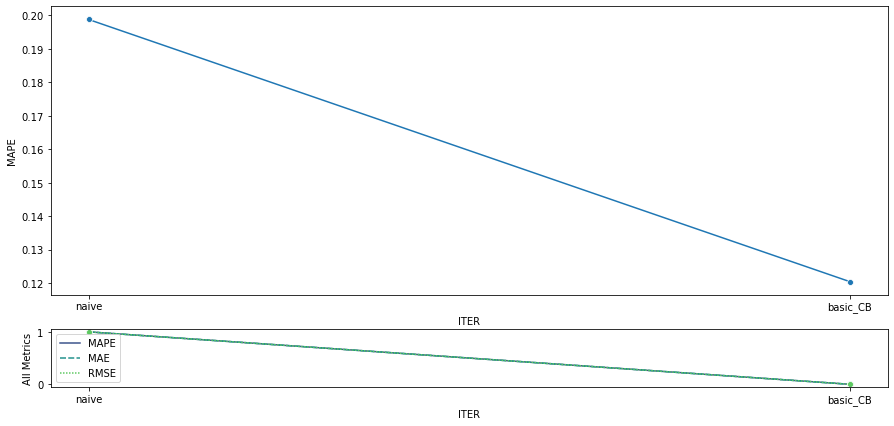

,naive,basic_CB
MAPE,0.1988,0.1205
MAE,347328.2433,237520.8892
RMSE,932296.7579,809406.7829


In [43]:
X = data[data.train==1].drop(['train','description','sell_id','price'], axis=1)
y = data[data.train==1]['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RS)
del X, y

for col in tqdm(cat_cols+bin_cols):
    X_train[col].fillna('NS', inplace=True)
    X_test[col].fillna('NS', inplace=True)
    
CB = CatBoostRegressor(random_seed = RS, silent=True)
CB.fit(X_train, np.log(y_train+1), 
          cat_features=cat_cols+bin_cols)
preds = CB.predict(X_test)


# Пост-обработка
preds = ((np.exp(preds)-1) // 1000) * 1000

# Расчет и запись метрик
results['basic_CB'] = metrics(y_test, preds)

# Визуализация
plot_results(results, 'MAPE')
results

CatBoost показывает довольно хороший результат и не требует предобработки.

# Feature Engineering

Генерация дополнительных признаков перенесена на данный датасэт из предидущего проэкта, где они были протестированы при помощи CatBoost с 3-ой кросс-валидацией.

## Stats

### Model
Модели авто будут рассмотрены по каждому бренду. Для каждой моделей рассчитаем среднеарифметическое стандартизированых средней и максимальной цен.

- Это позволит нивелировать ошибку среднего (к примеру, если модель представлена более старыми авто, среднее значение будет ниже и не отобразит относительной цены), и ошибку максимума (к примеру, уникальная комплектация модели, выброс в большую сторону, завышающщий относительную цену модели). Если модель присутствует только в тесте, берется среднеарифметическое по бренду. Далее, упорядочиваем модели по статистике внутри бренда и стандартизируем позицию. Таким образом, мы получаем относительное положение модели внутри линейки бренда (самые дорогие авто = 1, самые дешевые = 0).

In [44]:
# Функция возвращает значение, если оно имеется
# В противном случае 'None'
def get_price(df, model):
    try:
        return df[model]
    except:
        return None

In [45]:
# Расчет относительного рейтинга модели
mapping_dict = {}
for mark in tqdm(data.brand.unique()):
    stat = pd.DataFrame({'model':data[data.brand==mark].model_info.unique()})
    stat_max = data[(data.train==1)&(data.brand==mark)].groupby('model_info').price.max()
    stat['max_price'] = stat.model.apply(lambda x: get_price(stat_max, x))
    stat_mean = data[(data.train==1)&(data.brand==mark)].groupby('model_info').price.mean()
    stat['mean_price'] = stat.model.apply(lambda x: get_price(stat_mean, x))
    max_price_range = stat.max_price.max() - stat.max_price.min()
    mean_price_range = stat.mean_price.max() - stat.mean_price.min()
    stat['stat'] = ((stat.max_price-stat.max_price.min())/max_price_range 
                    + (stat.mean_price-stat.mean_price.min())/mean_price_range)/2
    stat['stat'] = stat.stat.fillna(stat.stat.mean())
    stat.sort_values(by='stat',inplace = True)
    stat.reset_index(drop=True, inplace = True)
    stat['ordinal_code'] = stat.index
    stat.stat.fillna(stat.stat.mean())
    for i in stat.index:
        mapping_dict[stat.loc[i]['model']] = stat.loc[i]['ordinal_code']/stat['ordinal_code'].max()

In [46]:
data['rel_model'] = data.model_info.map(mapping_dict)
num_cols.append('rel_model')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


REL_MODEL
mean   0.5185
std    0.2411
min    0.0000
25%    0.3333
50%    0.5455
75%    0.6774
max    1.0000
Name: rel_model, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



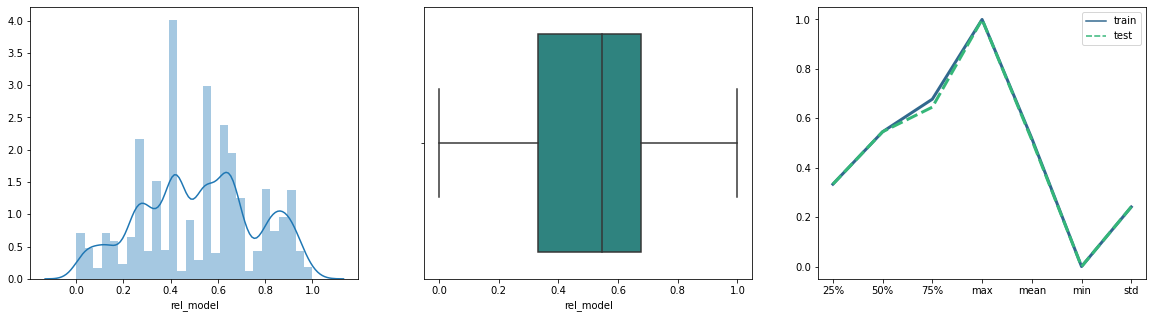

In [47]:
sum_up_num(data, 'rel_model', 'price')

### Decades
Так как зависимость возраста авто и его цены нелинейна (наиболее старые и новые авто дороже), имеет смысл поэксперементировать с разделением времени на отрезки. Несмотря на то,что в градиентный бустинг встроен подобный алгоритм, эксперимент может быть полезен.

In [48]:
data['decade'] = (2021 - data.productionDate).apply(lambda x: (int(x/10))*10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
stat = pd.DataFrame({'decade':data.decade.unique()})
stat_max = data[data.train==1].groupby('decade').price.max()
stat['max_price'] = stat.decade.apply(lambda x: get_price(stat_max, x))
stat_avg = data[data.train==1].groupby('decade').price.mean()
stat['mean_price'] = stat.decade.apply(lambda x: get_price(stat_avg, x))
stat.sort_values(by='decade',inplace = True)
stat.fillna(method='backfill', inplace = True)
max_price_range = stat.max_price.max() - stat.max_price.min()
mean_price_range = stat.mean_price.max() - stat.mean_price.min()
stat['stat'] = ((stat.max_price-stat.max_price.min())/max_price_range 
                + (stat.mean_price-stat.mean_price.min())/mean_price_range)/2
stat.sort_values(by='stat',inplace = True)
stat.reset_index(drop=True, inplace = True)
stat['ordinal_code'] = stat.index
stat

,decade,max_price,mean_price,stat,ordinal_code
0,1980,3500000.0000,1001943.8889,0.0180,0
1,1990,4500000.0000,952093.3000,0.0385,1
2,2000,23900000.0000,777511.8682,0.5000,2
3,2010,23000000.0000,2214863.6391,0.5931,3
4,2020,18700000.0000,7017365.0244,0.8725,4


In [50]:
# Добавление параметра
mapping_dict = {}
for i in range(stat.shape[0]):
    mapping_dict[stat.decade.loc[i]] = stat.stat.loc[i]
data['decade'] = data.decade.map(mapping_dict)
num_cols.append('decade')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Прочие признаки:

Были протестированы ряд дополнительных признаков:
- Километраж в год: data.mileage/data.productionDate
- Доп. классификация цвета: 4 класса по популярности
- "Спортивный" индекс: data.eng_pwr/data.numberOfDoors
- Так же проводилось удаление признаков

В ходе эксперементов, ограниченно полезеным себя показал только "спортивный" индекс, который немного улучшает результат для CatBoost и нейросети на табличных данных.

In [51]:
data['sport_idx'] = data.eng_pwr/data.numberOfDoors

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


SPORT_IDX
mean    64.7366
std     39.5466
min     15.0000
25%     42.5000
50%     49.8000
75%     73.4000
max    313.0000
Name: sport_idx, dtype: float64
Кол-во выбросов: 436 	 (%%: 6.53)



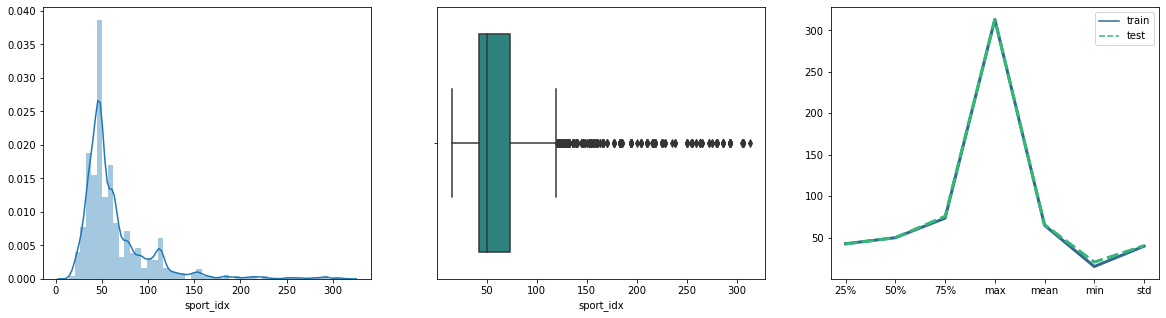

In [52]:
sum_up_num(data, 'sport_idx', 'price')

## Результат

In [53]:
# В meta_submission хронятся предсказания моделей
meta_submission = data[data.train==0][['sell_id']].copy().reset_index(drop=True)

# Функция добавляет предсказания в meta_submission
def submit(preds, ids, prefix='none'):
    submission = sample_submission.copy()
    submission['sell_id'] = ids
    submission['price'] = preds
    global meta_submission
    meta_submission = meta_submission.merge(submission, on='sell_id')
    meta_submission.columns = meta_submission.columns[:-1].to_list()+[prefix]

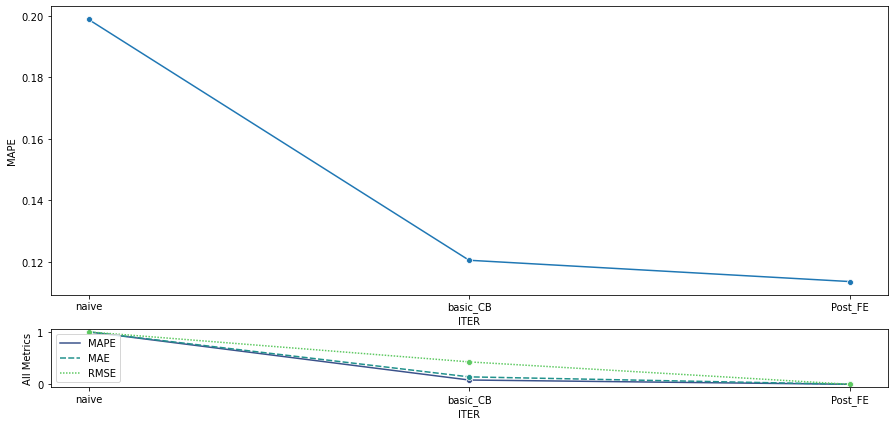

,naive,basic_CB,Post_FE
MAPE,0.1988,0.1205,0.1135
MAE,347328.2433,237520.8892,219443.2246
RMSE,932296.7579,809406.7829,717792.6556


In [54]:
X = data[data.train==1].drop(['train','description','sell_id','price'], axis=1)
y = data[data.train==1]['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RS)
del X, y
X_sub = data[data.train==0].drop(['train','description','sell_id','price'], axis=1)
ids_sub = data[data.train==0]['sell_id'].values

for col in tqdm(cat_cols+bin_cols):
    X_train[col].fillna('NS', inplace=True)
    X_test[col].fillna('NS', inplace=True)
    X_sub[col].fillna('NS', inplace=True)
    
CB = CatBoostRegressor(iterations = 5000, random_seed = RS, silent=True, eval_metric='MAPE', use_best_model=True)
eval_dataset = Pool(X_test, np.log(y_test+1), cat_features=cat_cols+bin_cols)
CB.fit(X_train, np.log(y_train+1), 
       cat_features=cat_cols+bin_cols,
       eval_set=eval_dataset)
CB_preds = CB.predict(X_test)
sub_preds = CB.predict(X_sub)


# Пост-обработка
CB_preds = ((np.exp(CB_preds)-1) // 1000) * 1000
sub_preds = ((np.exp(sub_preds)-1) // 1000) * 1000

# Расчет и запись метрик
results['Post_FE'] = metrics(y_test, CB_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(sub_preds, ids_sub, prefix='CB')

Feature engineering и self-tuning модели дали снижение целевой метрики.

# Random Forest

Альтернатива CatBoost. Данный алгоритм показал себя наилучшим образом в предидущщем проекте на скрытой выборке Kaggle.

Данные будут обработаны таким образом, чтобы им можно было использовать на падачу Random Forest и нейросети.

Этапы предобработки:
- Кодирование бинарных переменных (LabelEncoder)
- Кодировние категориальных признаков (dummy-переменные)
- Заполнение eng_power значением 0.0 для электромобилей
- Логорифмирование числовых переменных, кроме mileage, для приведения к нормальному распределению и снижения выбросов.
- Стандартизация числовых переменных (MinMaxScaler)

In [55]:
# Функция предобработки данных
def prepoc(df):
    alt_data = df.copy()
    alt_data.reset_index(drop=True, inplace=True)
    
    LE = LabelEncoder()
    for col in bin_cols:
        alt_data[col] = LE.fit_transform(alt_data[col])
    
    for col in cat_cols:
        if len(alt_data[col].isna().unique())>1:
            alt_data = pd.get_dummies(alt_data, dummy_na=True, columns=[col])
        else:
            alt_data = pd.get_dummies(alt_data, dummy_na=False, columns=[col])
    
    alt_data.fillna(0.0, inplace=True)
    
    for col in ['modelDate','productionDate','eng_volume',
                'eng_pwr','own_time','rel_model','sport_idx']:
        alt_data[col] = np.log(alt_data[col]+1)
    
    MMS = MinMaxScaler()
    for col in ['mileage', 'modelDate', 'productionDate', 
                'eng_volume', 'eng_pwr', 'own_time',
                'rel_model','sport_idx']:
        alt_data[col] = MMS.fit_transform(alt_data[col].values.reshape(-1, 1))
    
    return alt_data

In [56]:
# Результат обработки
proc_data = prepoc(data)
pd.options.display.max_columns = proc_data.shape[1]
proc_data.sample(3)

,description,mileage,modelDate,price,productionDate,sell_id,ПТС,train,eng_volume,eng_pwr,own_time,rel_model,decade,sport_idx,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_минивэн,bodyType_пикап двойная кабина,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_универсал 5 дв.,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 5 дв.,brand_AUDI,brand_BMW,brand_MERCEDES,color_бежевый,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_розовый,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_бензин,fuelType_гибрид,fuelType_дизель,fuelType_электро,model_info_100,model_info_1ER,model_info_2ACTIVETOURER,model_info_2ER,model_info_2GRANDTOURER,model_info_3ER,model_info_4,model_info_5ER,model_info_6ER,model_info_7ER,model_info_8ER,model_info_A1,model_info_A3,model_info_A4,model_info_A4_ALLROAD,model_info_A5,model_info_A6,model_info_A7,model_info_A8,model_info_ALLROAD,model_info_AMG_GLC_COUPE,model_info_AMG_GT,model_info_A_KLASSE,model_info_A_KLASSE_AMG,model_info_B_KLASSE,model_info_CITAN,model_info_CLA_KLASSE,model_info_CLA_KLASSE_AMG,model_info_CLC_KLASSE,model_info_CLK_KLASSE,model_info_CLS_KLASSE,model_info_CLS_KLASSE_AMG,model_info_CL_KLASSE,model_info_CL_KLASSE_AMG,model_info_COUPE,model_info_C_KLASSE,model_info_C_KLASSE_AMG,model_info_E_KLASSE,model_info_E_KLASSE_AMG,model_info_GLA_CLASS,model_info_GLA_CLASS_AMG,model_info_GLC_COUPE,model_info_GLC_KLASSE,model_info_GLC_KLASSE_AMG,model_info_GLE_KLASSE,model_info_GLE_KLASSE_AMG,model_info_GLE_KLASSE_COUPE,model_info_GLE_KLASSE_COUPE_AMG,model_info_GLK_KLASSE,model_info_GLS_KLASSE,model_info_GLS_KLASSE_AMG,model_info_GL_KLASSE,model_info_GL_KLASSE_AMG,model_info_G_KLASSE,model_info_G_KLASSE_AMG,model_info_I3,model_info_I8,model_info_M1,model_info_M2,model_info_M3,model_info_M4,model_info_M5,model_info_M6,model_info_M_KLASSE,model_info_M_KLASSE_AMG,model_info_None,model_info_Q3,model_info_Q5,model_info_Q7,model_info_Q8,model_info_R8,model_info_RS3,model_info_RS4,model_info_RS5,model_info_RS6,model_info_RS7,model_info_RSQ3,model_info_R_KLASSE,model_info_S3,model_info_S4,model_info_S5,model_info_S6,model_info_S7,model_info_S8,model_info_SLC_KLASSE,model_info_SLC_KLASSE_AMG,model_info_SLK_KLASSE,model_info_SLK_KLASSE_AMG,model_info_SLR_KLASSE,model_info_SLS_AMG,model_info_SL_KLASSE,model_info_SL_KLASSE_AMG,model_info_SQ5,model_info_SQ7,model_info_S_CLASS_MAYBACH,model_info_S_KLASSE,model_info_S_KLASSE_AMG,model_info_TT,model_info_TTS,model_info_VIANO,model_info_VITO,model_info_V_KLASSE,model_info_W123,model_info_W124,model_info_W201,model_info_X1,model_info_X2,model_info_X3,model_info_X3_M,model_info_X4,model_info_X4_M,model_info_X5,model_info_X5_M,model_info_X6,model_info_X6_M,model_info_X7,model_info_X_KLASSE,model_info_Z1,model_info_Z3,model_info_Z3M,model_info_Z4,model_info_Z8,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Владельцы_1 владелец,Владельцы_2 владельца,Владельцы_3 или более,Владельцы_nan,Привод_задний,Привод_передний,Привод_полный,numberOfDoors_2,numberOfDoors_3,numberOfDoors_4,numberOfDoors_5
7735,Автомобиль приобретён у официального дилера в ...,0.1250,0.4893,0.0000,0.5021,1098767222,1,0,0.8315,0.7564,0.7582,0.7105,0.5931,0.5506,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
7078,"В продаже автомобили от компании АО ABTODOM, о...",0.0337,0.0000,0.0000,0.1353,1099509748,1,0,0.5417,0.4310,0.0000,0.4854,0.5931,0.31

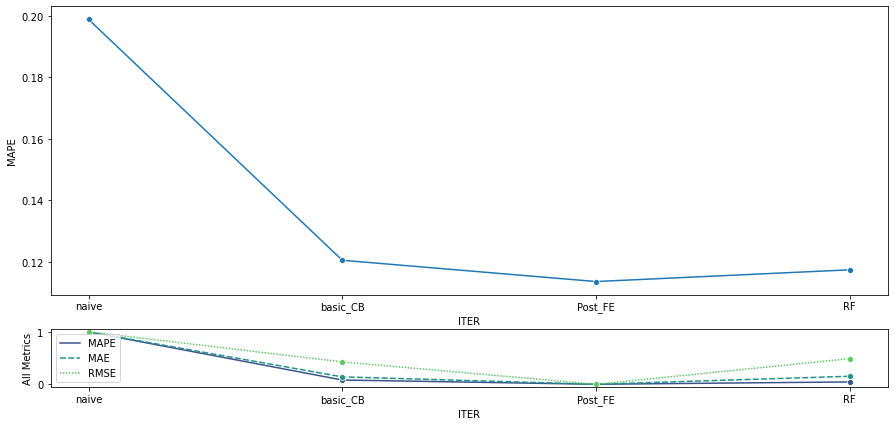

,naive,basic_CB,Post_FE,RF
MAPE,0.1988,0.1205,0.1135,0.1174
MAE,347328.2433,237520.8892,219443.2246,238957.6976
RMSE,932296.7579,809406.7829,717792.6556,822549.9388


In [57]:
# Моделирование Random Forest
X = proc_data[proc_data.train==1].drop(['train','description','sell_id','price'], axis=1)
y = proc_data[proc_data.train==1]['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RS)
del X, y
X_sub = proc_data[proc_data.train==0].drop(['train','description','sell_id','price'], axis=1)
ids_sub = proc_data[proc_data.train==0]['sell_id'].values

RF = RandomForestRegressor(n_estimators=1400, min_samples_split=5, 
                              min_samples_leaf=1, max_features='sqrt', 
                              max_depth=80, bootstrap=False, random_state=RS)
RF.fit(X_train.drop('sport_idx', axis=1), np.log(y_train+1))
RF_preds = RF.predict(X_test.drop('sport_idx', axis=1))
sub_preds = RF.predict(X_sub.drop('sport_idx', axis=1))

# Пост-обработка
RF_preds = ((np.exp(RF_preds)-1) // 1000) * 1000
sub_preds = ((np.exp(sub_preds)-1) // 1000) * 1000

# Расчет и запись метрик
results['RF'] = metrics(y_test, RF_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(sub_preds, ids_sub, prefix='RF')

Ожидаемо, на тестовой выборке, Random Forest проигрывает CatBoost.

# Neural Networks

## NN на табличных данных

In [58]:
K.clear_session()
tf.random.set_seed(RS)

model = Sequential()
model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="selu"))
model.add(L.Dense(512, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              192512    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 848,897
Trainable params: 848,897
Non-trainable params: 0
__________________________________________________

In [59]:
# Compile model
optimizer = tf.keras.optimizers.Adamax(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [60]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [61]:
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

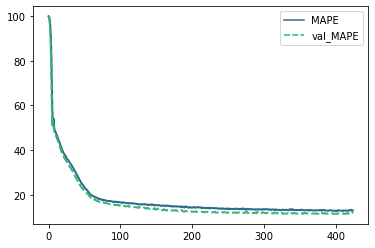

In [62]:
sns.lineplot(data=pd.DataFrame({'MAPE':history.history['MAPE'], 'val_MAPE':history.history['val_MAPE']}), 
             palette='viridis', linewidth=2)

In [63]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

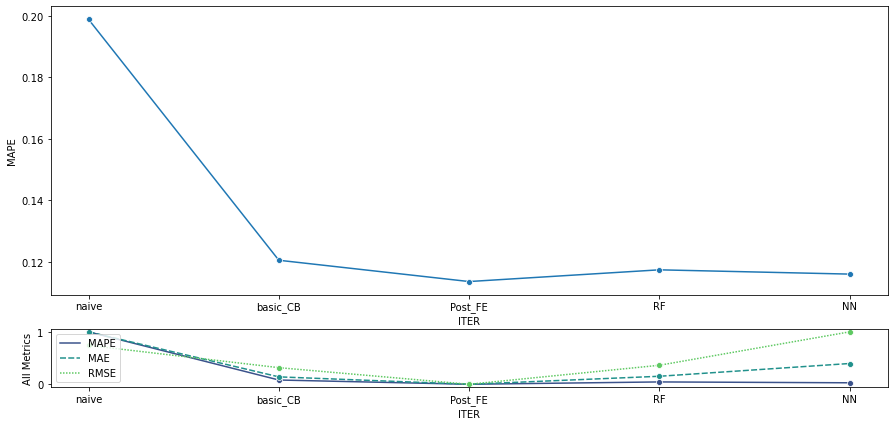

,naive,basic_CB,Post_FE,RF,NN
MAPE,0.1988,0.1205,0.1135,0.1174,0.1160
MAE,347328.2433,237520.8892,219443.2246,238957.6976,270098.8134
RMSE,932296.7579,809406.7829,717792.6556,822549.9388,1006880.2245


In [64]:
nn_preds = model.predict(X_test)
nn_preds = nn_preds.reshape(1,-1)[0]
sub_preds = model.predict(X_sub)
sub_preds = sub_preds.reshape(1,-1)[0]

# Пост-обработка
nn_preds = (nn_preds // 1000) * 1000
sub_preds = (sub_preds // 1000) * 1000

# Расчет и запись метрик
results['NN'] = metrics(y_test, nn_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(sub_preds, ids_sub, prefix='NN')

Нейросеть на табличных данных показывает чуть лучший результат, чем RandomForest. Стоит отметить, что у нейросети значительно выше MAE и RMSE. Иными словами, данный алгоритм хуже предсказывает выбросы в большую сторону, но лучше предсказывает общую совокупность.

Из-за подобной разности результатов моделей, их блэнд может дать значительные улучшения.

In [65]:
print('MAPE (CatBoost bland):\t\t',(metrics(y_test, (nn_preds+CB_preds)/2))[0])
print('MAPE (RandomForest bland):\t',(metrics(y_test, (nn_preds+RF_preds)/2))[0])
print('MAPE (Meta bland):\t\t',(metrics(y_test, (nn_preds+CB_preds+RF_preds)/3))[0])

MAPE (CatBoost bland):		 0.10836439124243256
MAPE (RandomForest bland):	 0.10950898658709367
MAPE (Meta bland):		 0.1074821869332298


## NN на табличных данных c пробросом.

Для начала посмотрим наиболее полезные признаки для CatBoost и RandomForest.

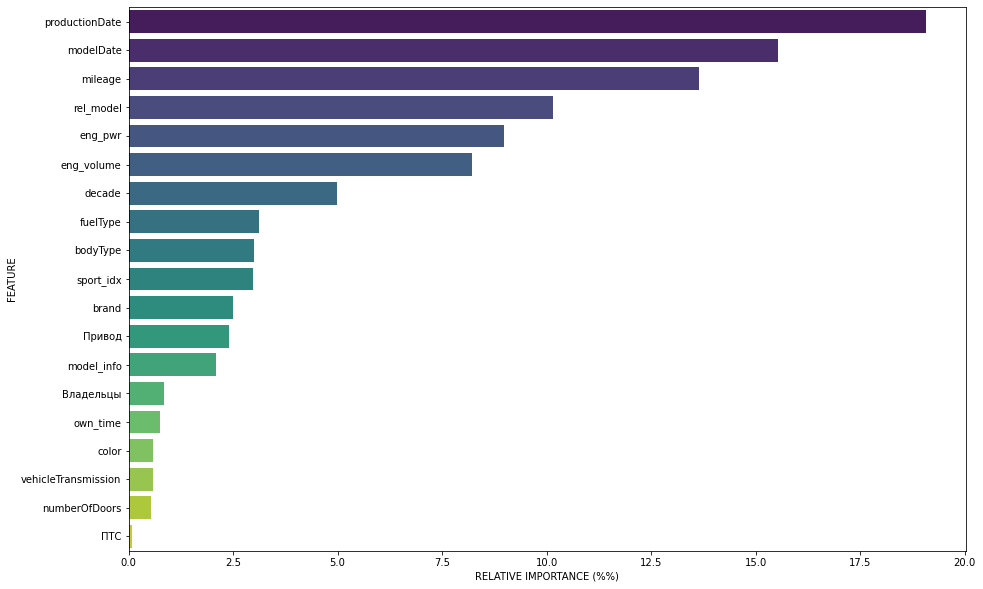

,productionDate,modelDate,mileage,rel_model,eng_pwr,eng_volume,decade,fuelType,bodyType,sport_idx,brand,Привод,model_info,Владельцы,own_time,color,vehicleTransmission,numberOfDoors,ПТС
score,19.0633,15.5216,13.6329,10.1582,8.9817,8.2127,4.9798,3.1256,3.0015,2.9759,2.4933,2.3957,2.0885,0.8579,0.7489,0.5814,0.5798,0.5282,0.0732


In [66]:
# CatBooost
cols = data.drop(['train','description','sell_id','price'], axis=1).columns
CB_FI = pd.Series(CB.get_feature_importance(), index=cols).sort_values(ascending=False)
    
# Визуализация
plt.figure(figsize=(15,10))
ax = sns.barplot(x=CB_FI.values, y=CB_FI.index, palette = 'viridis')
ax.set(ylabel='FEATURE', xlabel='RELATIVE IMPORTANCE (%%)')
plt.show()
display(pd.DataFrame(CB_FI, columns=['score']).T)

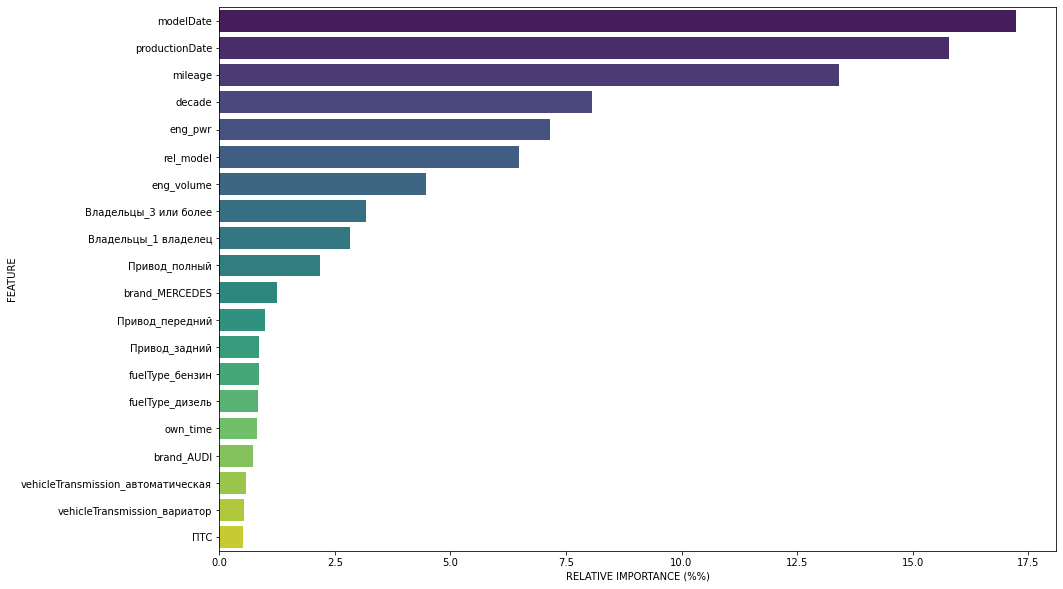

,modelDate,productionDate,mileage,decade,eng_pwr,rel_model,eng_volume,Владельцы_3 или более,Владельцы_1 владелец,Привод_полный,brand_MERCEDES,Привод_передний,Привод_задний,fuelType_бензин,fuelType_дизель,own_time,brand_AUDI,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,ПТС
score,17.2424,15.7757,13.4159,8.0689,7.1645,6.4794,4.4701,3.1810,2.8320,2.1851,1.2413,0.9965,0.8593,0.8573,0.8401,0.8174,0.7284,0.5877,0.5385,0.5224


In [67]:
cols = proc_data.drop(['train','description','sell_id','price','sport_idx'], axis=1).columns
RF_FI = pd.Series(RF.feature_importances_, index=cols).sort_values(ascending=False)
RF_FI = RF_FI*100
    
# Визуализация
plt.figure(figsize=(15,10))
ax = sns.barplot(x=RF_FI[RF_FI>=0.5].values, y=RF_FI[RF_FI>=0.5].index, palette = 'viridis')
ax.set(ylabel='FEATURE', xlabel='RELATIVE IMPORTANCE (%%)')
plt.show()
display(pd.DataFrame(RF_FI[RF_FI>=0.5], columns=['score']).T)

Корреляционная матрица:

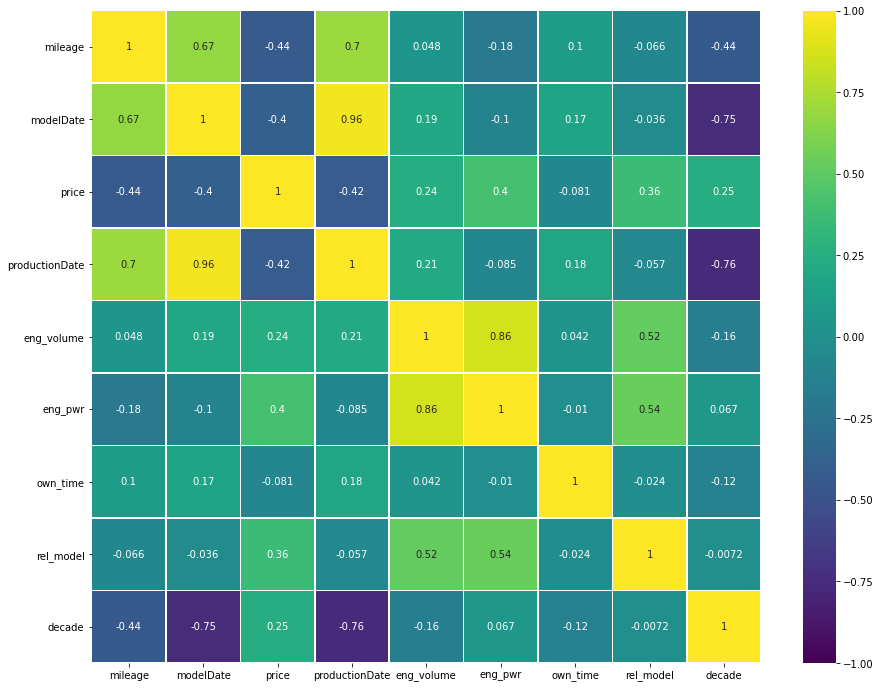

In [68]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data[num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Для ансаблей деревьев решений наиболее полезны признаки productionDate и modelDate, mileage. Корреляционая матрица также подтверждает их полезность. Тем не менее, имеет смысл избавиться от modelDate, т.к. он дублирует productionDate и чуть меньше скоррелирован с целевой переменной.

### Модель

In [69]:
K.clear_session()
tf.random.set_seed(RS)

model_mlp = Sequential()
model_mlp.add(L.Dense(1024, input_dim=X_train.shape[1], activation="selu"))
model_mlp.add(L.Dense(512, activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [70]:
productiondate = L.Input(shape=[1], name="productiondate")
emb_productiondate = L.Embedding(len(data.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [71]:
mileage = L.Input(shape=[1], name="mileage")
emb_mileage = L.Embedding(len(data.mileage.unique().tolist())+1, 20)(mileage)
f_mileage = L.Flatten()(emb_mileage)

In [72]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate, f_mileage])

head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate, mileage], outputs=head)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 187)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         192512      dense_input[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          524800      dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512)          0           dense_1[0][0]                    
_______________________________________________________________________________________

In [73]:
# Compile model
optimizer = tf.keras.optimizers.Adamax(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [74]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [75]:
history = model.fit([X_train, X_train.productionDate.values, X_train.mileage.values], y_train,
                    batch_size=1024,
                    epochs=500,
                    validation_data=([X_test, X_test.productionDate.values, X_test.mileage.values], y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

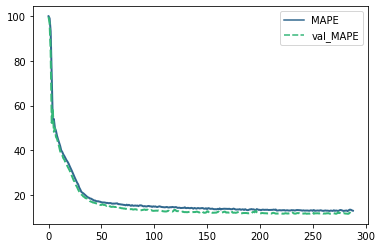

In [76]:
sns.lineplot(data=pd.DataFrame({'MAPE':history.history['MAPE'], 'val_MAPE':history.history['val_MAPE']}), 
             palette='viridis', linewidth=2)

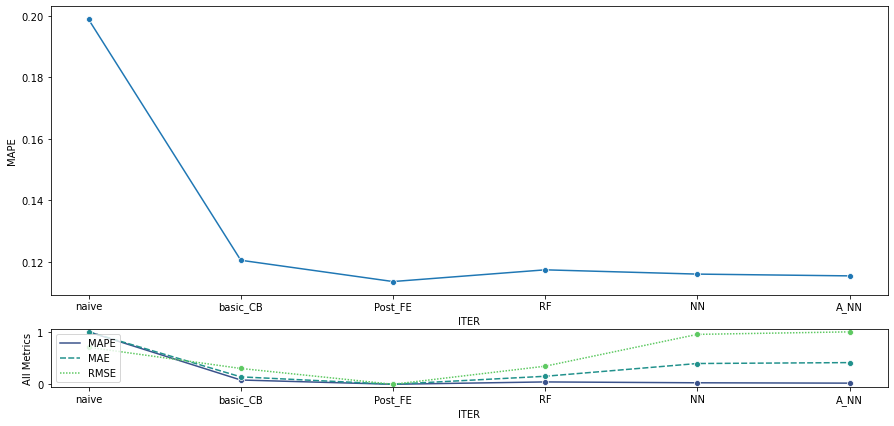

,naive,basic_CB,Post_FE,RF,NN,A_NN
MAPE,0.1988,0.1205,0.1135,0.1174,0.1160,0.1154
MAE,347328.2433,237520.8892,219443.2246,238957.6976,270098.8134,272311.8952
RMSE,932296.7579,809406.7829,717792.6556,822549.9388,1006880.2245,1021443.5775


In [77]:
add_nn_preds = model.predict([X_test, X_test.productionDate.values, X_test.mileage.values])
add_nn_preds = add_nn_preds.reshape(1,-1)[0]
sub_preds = model.predict([X_sub, X_sub.productionDate.values, X_sub.mileage.values])
sub_preds = sub_preds.reshape(1,-1)[0]

# Пост-обработка
add_nn_preds = (add_nn_preds // 1000) * 1000
sub_preds = (sub_preds // 1000) * 1000

# Расчет и запись метрик
results['A_NN'] = metrics(y_test, add_nn_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(sub_preds, ids_sub, prefix='A_NN')

In [78]:
print('MAPE (CatBoost bland):\t\t',(metrics(y_test, (add_nn_preds+CB_preds)/2))[0])
print('MAPE (RandomForest bland):\t',(metrics(y_test, (add_nn_preds+RF_preds)/2))[0])
print('MAPE (Meta bland):\t\t',(metrics(y_test, (add_nn_preds+CB_preds+RF_preds)/3))[0])

MAPE (CatBoost bland):		 0.10859015026302418
MAPE (RandomForest bland):	 0.10977907620454677
MAPE (Meta bland):		 0.10787381759990625


Нейросеть с пробросом признаков неплохой результат. Тем не менее, блэнды с деревьями показывают себя заметно хуже. По этой причине, проброс применяться не будет.

In [79]:
meta_submission.drop('A_NN', axis=1, inplace=True)

# NLP

Слова в тексте будут лемминизированы и токенизированы по средствам FastText в вектора с размерностью 256 измерений. Далее, для каждого текста данные вектора суммируются. Таким, образом на вход подается схожий вектор, абстректная сумма всех слов в тексте.

Обрабатыввется вектор нейросетью аналогичной той, что использовалась для табличных данный. В ходе экспериментов данный подход дал лучший результат по сравнению с LSTM-сетью.

## Предобработка

In [80]:
proc_data.description

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
8346    Продаётся любимица семьи. Автомобилем неактивн...
8347    В продаже автомобиль от компании АО ABTODOM, о...
8348    Машина в идеальном техническом состоянии. Обсл...
8349    Автомобиль приобретался новым у дилера Avilon ...
8350    ID: 38887\nКомплектация-Comfort\nГод выпуска в...
Name: description, Length: 8351, dtype: object

Перед тем, как обрабатывать текст, желательно сразу почистить его. Бросается в глаза, замена "\n" на пробел. Так же, можно удалить числа.

In [81]:
# Определение лемминизатора и стоп-слов
mystem = Mystem()
ru_stopwords = stopwords.words("russian")
for word in ['нет','не']:
    ru_stopwords.remove(word)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [82]:
# Функция возвращает лемминизированный текст
def preprocess_text(text):
    text = text.replace('\n',' ')
    for i in punctuation:
        text = text.replace(i,' ')
    text = ''.join(i for i in text if not i.isdigit())
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in ru_stopwords and token != " " and token[0] != " "]
    
    text = " ".join(tokens)
    
    return " ".join(tokens)

In [83]:
proc_data['description'] = proc_data.description.progress_apply(preprocess_text)
proc_data.description

0       авто бодрый ход работать отлично электрика ход...
1       продажа собственник второй владелец птс оригин...
2       внимание клиент avilon автомобиль пробег предл...
3       комплект зимний колесо замена передний тормозн...
4       отличный авто год выпуск кроме передний левый ...
                              ...                        
8346    продаваться любимица семья автомобиль неактивн...
8347    продажа автомобиль компания ао abtodom официал...
8348    машина идеальный технический состояние обслужи...
8349    автомобиль приобретаться новый дилер avilon ок...
8350    id комплектация comfort год выпуск птс г компл...
Name: description, Length: 8351, dtype: object

In [84]:
#Векторизация слов
FT = FastText(sentences=proc_data.description.str.split(' '), size=256, window=5, min_count=1, min_n=1)

In [85]:
FT.most_similar('двигатель')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('турбодвигатель', 0.9401307106018066),
 ('saдвигатель', 0.9196980595588684),
 ('двинатель', 0.8993620276451111),
 ('двиготель', 0.8913775682449341),
 ('двигат', 0.8296276330947876),
 ('двитель', 0.8291102051734924),
 ('мечтатель', 0.7699565887451172),
 ('обладатель', 0.7648537158966064),
 ('двигательный', 0.76347815990448),
 ('выключатель', 0.7603157758712769)]

In [86]:
#Функция возвращщает сумму векторов в тексте
def txt_vector(string):
    txt = string.split(' ')
    vec = np.zeros(256)
    for word in txt:
        vec+=FT.wv[word]
    return vec

In [87]:
# split данных
text_train = proc_data.description.iloc[X_train.index]
text_test = proc_data.description.iloc[X_test.index]
text_sub = proc_data.description.iloc[X_sub.index]

In [88]:
#Преобразование текта
MMS = MinMaxScaler()
text_train_sequences = sequence.pad_sequences(text_train.progress_apply(txt_vector), dtype='float32', maxlen=256)
text_test_sequences = sequence.pad_sequences(text_test.progress_apply(txt_vector), dtype='float32', maxlen=256)
text_sub_sequences = sequence.pad_sequences(text_sub.progress_apply(txt_vector), dtype='float32', maxlen=256)

MMS.fit(np.concatenate((text_train_sequences, text_test_sequences, text_sub_sequences)))
text_train_sequences = MMS.transform(text_train_sequences)*1000
text_test_sequences = MMS.transform(text_test_sequences)*1000
text_sub_sequences = MMS.transform(text_sub_sequences)*1000

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape)
del text_train, text_test, text_sub, FT


(5678, 256) (1002, 256) (1671, 256)


## Модель

In [89]:
#Табличные данные
K.clear_session()
tf.random.set_seed(RS)

model = Sequential()
model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="selu"))
model.add(L.Dense(512, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              192512    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
Total params: 848,640
Trainable params: 848,640
Non-trainable params: 0
_________________________________________________________________


In [90]:
#Текст
model_nlp = Sequential()
model_nlp.add(L.Dense(1024, input_dim=256, activation="selu"))
model_nlp.add(L.Dense(512, input_dim=256, activation="relu"))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(256, activation="relu"))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, activation="relu"))

model_nlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
Total params: 935,744
Trainable params: 935,744
Non-trainable params: 0
________________________________________________

In [91]:
#Конкатенация сетей
combinedInput = L.concatenate([model_nlp.output, model.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

agg_model = Model(inputs=[model_nlp.input, model.input], outputs=head)
agg_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_3_input (InputLayer)      [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         263168      dense_3_input[0][0]              
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 187)]        0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          524800      dense_3[0][0]                    
_______________________________________________________________________________________

In [92]:
optimizer = tf.keras.optimizers.Adam(0.01)
agg_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [93]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE', verbose=0, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [94]:
history = agg_model.fit([text_train_sequences, X_train], y_train,
                    batch_size=1024,
                    epochs=500,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
6/6 [==============================] - 0s 64ms/step - loss: 75.2818 - MAPE: 75.2818 - val_loss: 53.7794 - val_MAPE: 53.7794
Epoch 2/500
6/6 [==============================] - 0s 30ms/step - loss: 56.1945 - MAPE: 56.1945 - val_loss: 49.6861 - val_MAPE: 49.6861
Epoch 3/500
6/6 [==============================] - 0s 9ms/step - loss: 52.3369 - MAPE: 52.3369 - val_loss: 50.3651 - val_MAPE: 50.3651
Epoch 4/500
6/6 [==============================] - 0s 28ms/step - loss: 51.1898 - MAPE: 51.1898 - val_loss: 48.5316 - val_MAPE: 48.5316
Epoch 5/500
6/6 [==============================] - 0s 43ms/step - loss: 46.5144 - MAPE: 46.5144 - val_loss: 39.8187 - val_MAPE: 39.8187
Epoch 6/500
6/6 [==============================] - 0s 28ms/step - loss: 38.9325 - MAPE: 38.9325 - val_loss: 35.7755 - val_MAPE: 35.7755
Epoch 7/500
6/6 [==============================] - 0s 28ms/step - loss: 34.7928 - MAPE: 34.7928 - val_loss: 32.1067 - val_MAPE: 32.1067
Epoch 8/500
6/6 [==============================] 

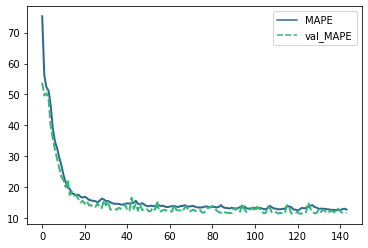

In [95]:
sns.lineplot(data=pd.DataFrame({'MAPE':history.history['MAPE'], 'val_MAPE':history.history['val_MAPE']}), 
             palette='viridis', linewidth=2)

In [96]:
agg_model.load_weights('../working/best_model.hdf5')
agg_model.save('../working/nn_mlp_nlp.hdf5')

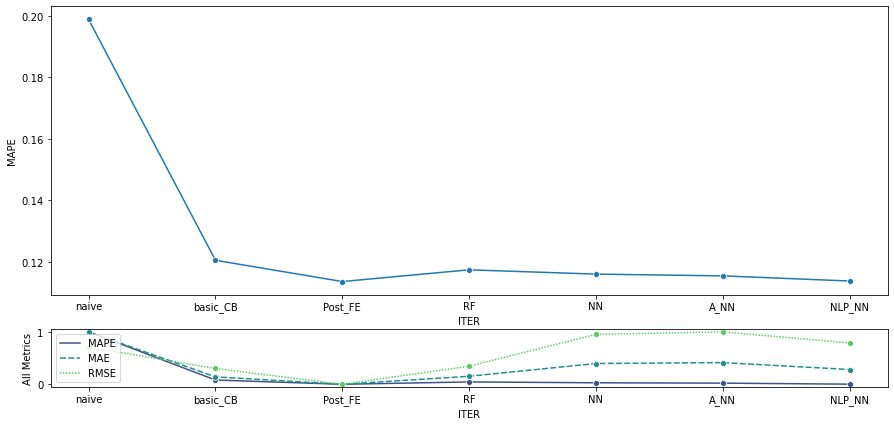

,naive,basic_CB,Post_FE,RF,NN,A_NN,NLP_NN
MAPE,0.1988,0.1205,0.1135,0.1174,0.1160,0.1154,0.1137
MAE,347328.2433,237520.8892,219443.2246,238957.6976,270098.8134,272311.8952,255480.3583
RMSE,932296.7579,809406.7829,717792.6556,822549.9388,1006880.2245,1021443.5775,957448.1834


In [97]:
nlp_nn_preds = agg_model.predict([text_test_sequences, X_test])
nlp_nn_preds = nlp_nn_preds.reshape(1,-1)[0]
sub_preds = agg_model.predict([text_sub_sequences, X_sub])
sub_preds = sub_preds.reshape(1,-1)[0]

# Пост-обработка
nlp_nn_preds = (nlp_nn_preds // 1000) * 1000
sub_preds = (sub_preds // 1000) * 1000

# Расчет и запись метрик
results['NLP_NN'] = metrics(y_test, nlp_nn_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(sub_preds, ids_sub, prefix='NLP_NN')

In [98]:
print('MAPE (Meta bland):\t\t', metrics(y_test, (nlp_nn_preds+CB_preds+RF_preds)/3)[0])

MAPE (Meta bland):		 0.10738593712310332


Добавление NLP нейросети дало небольшое улучшение результата. MAPE для блэнда так же снизился.

# CV

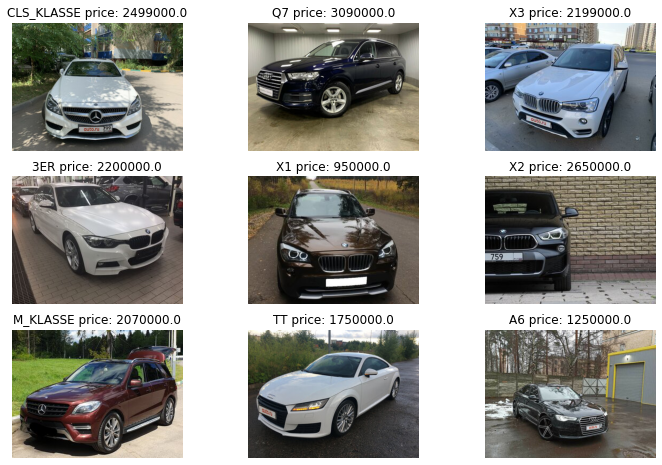

In [99]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9, random_state = RS)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values
random_image_model = random_image['model_info'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title(random_image_model[index] + ' price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [100]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5678, 240, 320, 3) dtype uint8
images shape (1002, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


## Аугументации:

(Применены изменение цветов, угла, оптическое искревление, смещение сетки, размытие и компрессия изображений)

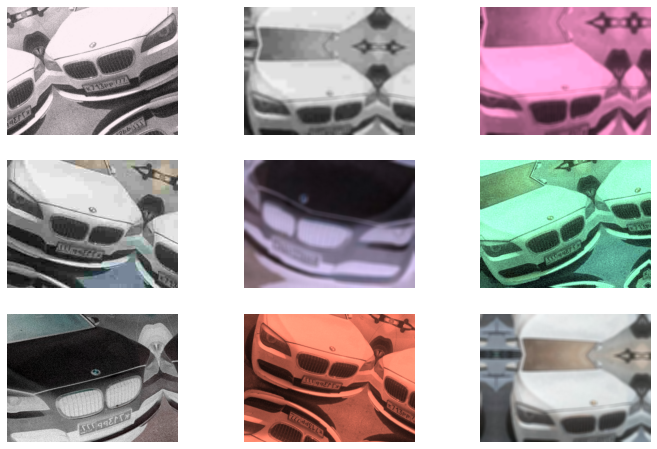

In [101]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, MultiplicativeNoise,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, JpegCompression,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, ToGray, InvertImg
)


augmentation = Compose([
    HorizontalFlip(),
    OneOf([ToGray(p=0.5)], p=0.25),
    OneOf([InvertImg(p=1), ToGray(p=0.25)], p=0.5),
    ShiftScaleRotate(shift_limit=0.3, scale_limit=0.2, rotate_limit=25, p=1),
    HorizontalFlip(p=0.5),
    OpticalDistortion(p=0.5),
    GridDistortion(p=0.25),
    IAAAdditiveGaussianNoise(p=1),
    OneOf([JpegCompression(quality_lower=5, quality_upper=50, p=1)], p=0.5),
    OneOf([
        Blur(blur_limit=(5, 10), p=0.5),
        RandomBrightnessContrast(),
    ], p=0.5),
    HueSaturationValue(p=0.3),
    MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, p=0.5)
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[1])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [102]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [103]:
len(make_augmentations(images_train[:3])[0])

применение аугментаций.


240

## Предлбработка данных

In [104]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, text_train_sequences, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, text_test_sequences, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, text_sub_sequences, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

## Модель

In [105]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
K.clear_session()
tf.random.set_seed(RS)

efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 2s 0us/step


In [106]:
#Табличные данные
tabular_model = Sequential()
tabular_model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="selu"))
tabular_model.add(L.Dense(512, activation="relu"))
tabular_model.add(L.Dropout(0.5))
tabular_model.add(L.Dense(256, activation="relu"))
tabular_model.add(L.Dropout(0.5))

tabular_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              192512    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
Total params: 848,640
Trainable params: 848,640
Non-trainable params: 0
_________________________________________________________________


In [107]:
#Текст
model_nlp = Sequential()
model_nlp.add(L.Dense(1024, input_dim=256, activation="selu"))
model_nlp.add(L.Dense(512, activation="relu"))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(256, activation="relu"))
model_nlp.add(L.Dropout(0.5))

model_nlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
Total params: 919,296
Trainable params: 919,296
Non-trainable params: 0
_________________________________________________________________


In [108]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, model_nlp.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, model_nlp.input], outputs=head)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [109]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [110]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [111]:
history = model.fit(train_dataset.batch(32),
                    epochs=200,
                    validation_data = test_dataset.batch(32),
                    callbacks=callbacks_list
                   )

Epoch 1/200
178/178 [==============================] - 116s 654ms/step - loss: 50.1588 - MAPE: 50.1588 - val_loss: 34.0369 - val_MAPE: 34.0369
Epoch 2/200
178/178 [==============================] - 113s 635ms/step - loss: 32.1731 - MAPE: 32.1731 - val_loss: 27.0530 - val_MAPE: 27.0530
Epoch 3/200
178/178 [==============================] - 113s 636ms/step - loss: 25.3027 - MAPE: 25.3027 - val_loss: 20.6303 - val_MAPE: 20.6303
Epoch 4/200
178/178 [==============================] - 113s 638ms/step - loss: 19.6930 - MAPE: 19.6930 - val_loss: 17.3981 - val_MAPE: 17.3981
Epoch 5/200
178/178 [==============================] - 112s 629ms/step - loss: 17.8372 - MAPE: 17.8372 - val_loss: 16.3280 - val_MAPE: 16.3280
Epoch 6/200
178/178 [==============================] - 113s 636ms/step - loss: 17.1835 - MAPE: 17.1835 - val_loss: 16.4303 - val_MAPE: 16.4303
Epoch 7/200
178/178 [==============================] - 112s 631ms/step - loss: 16.5669 - MAPE: 16.5669 - val_loss: 15.2117 - val_MAPE: 15.2117

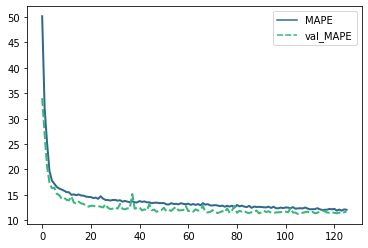

In [112]:
sns.lineplot(data=pd.DataFrame({'MAPE':history.history['MAPE'], 'val_MAPE':history.history['val_MAPE']}), 
             palette='viridis', linewidth=2)

In [113]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

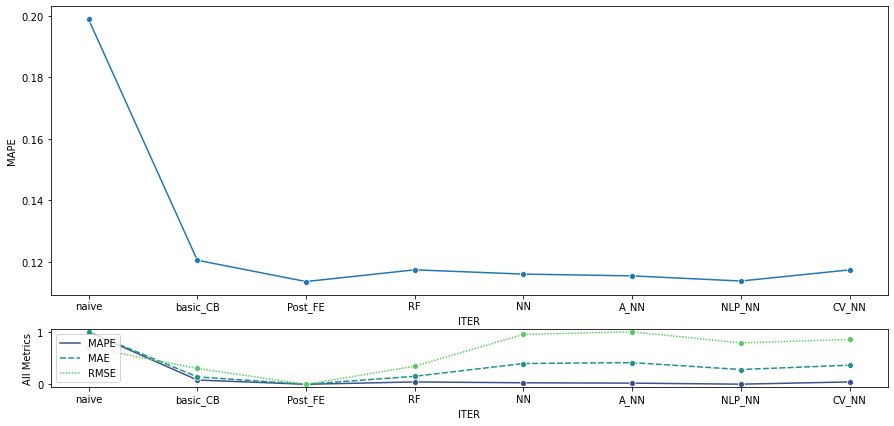

,naive,basic_CB,Post_FE,RF,NN,A_NN,NLP_NN,CV_NN
MAPE,0.1988,0.1205,0.1135,0.1174,0.1160,0.1154,0.1137,0.1173
MAE,347328.2433,237520.8892,219443.2246,238957.6976,270098.8134,272311.8952,255480.3583,265964.5838
RMSE,932296.7579,809406.7829,717792.6556,822549.9388,1006880.2245,1021443.5775,957448.1834,977447.7479


In [114]:
cv_nlp_nn_preds = model.predict(test_dataset.batch(32))
cv_nlp_nn_preds = cv_nlp_nn_preds.reshape(1,-1)[0]
sub_preds = model.predict(sub_dataset.batch(32))
sub_preds = sub_preds.reshape(1,-1)[0]

# Пост-обработка
cv_nlp_nn_preds = (cv_nlp_nn_preds // 1000) * 1000
sub_preds = (sub_preds // 1000) * 1000

# Расчет и запись метрик
results['CV_NN'] = metrics(y_test, cv_nlp_nn_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(sub_preds, ids_sub, prefix='CV_NN')

In [115]:
print('MAPE (Meta bland):\t\t', metrics(y_test, (cv_nlp_nn_preds+CB_preds+RF_preds)/3)[0])

MAPE (Meta bland):		 0.10776649982893932


Добавление изображений не улучшило метрику, блэнд так же чуть хуже, чем с NLP. Но, результат может быть иной на валидационной выборке.

# Submission & Blending

Для начала, загрузим результаты моделей из meta_submission.

In [116]:
meta_submission.sample(3)

,sell_id,CB,RF,NN,NLP_NN,CV_NN
557,1098510202,437000.0000,513000.0000,380000.0000,419000.0000,405000.0000
241,1092432196,8358000.0000,8369000.0000,6543000.0000,7485000.0000,7228000.0000
1225,1100233090,1324000.0000,1365000.0000,1331000.0000,1393000.0000,1331000.0000


In [117]:
for col in meta_submission.columns[1:]:
    submission = sample_submission.copy()
    submission['sell_id'] = meta_submission.sell_id.values
    submission['price'] = meta_submission[col].values
    submission.to_csv('{}_submission.csv'.format(col), index=False)

## Blendings

Блэндинг каждой из нейросетей с CatBooost и RandomForest:

In [118]:
for col in meta_submission.columns[3:]:
    for_blending = meta_submission[meta_submission.columns[:3].to_list()+[col]]
    for_blending['blend'] = for_blending[for_blending.columns[1:]].apply(lambda x: x.mean(), axis=1)
    submission = sample_submission.copy()
    submission['sell_id'] = for_blending.sell_id.values
    submission['price'] = for_blending['blend'].values
    submission.to_csv('blend_{}_submission.csv'.format(col), index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Блэндинг всех моделей:

In [119]:
for_blending = meta_submission.copy()
for_blending['blend'] = for_blending[for_blending.columns[1:]].apply(lambda x: x.mean(), axis=1)
submission = sample_submission.copy()
submission['sell_id'] = for_blending.sell_id.values
submission['price'] = for_blending['blend'].values
submission.to_csv('blend_full_submission.csv', index=False)

In [120]:
meta_submission['BLEND'] = for_blending['blend'].values

### Объединение результатов

Так как нейросети показывали больший MAE и RMSE при схожем MAPE, можно попробовать взять предсказание нейросети для более дешевых авто, и CatBoost для более дорогих авто.

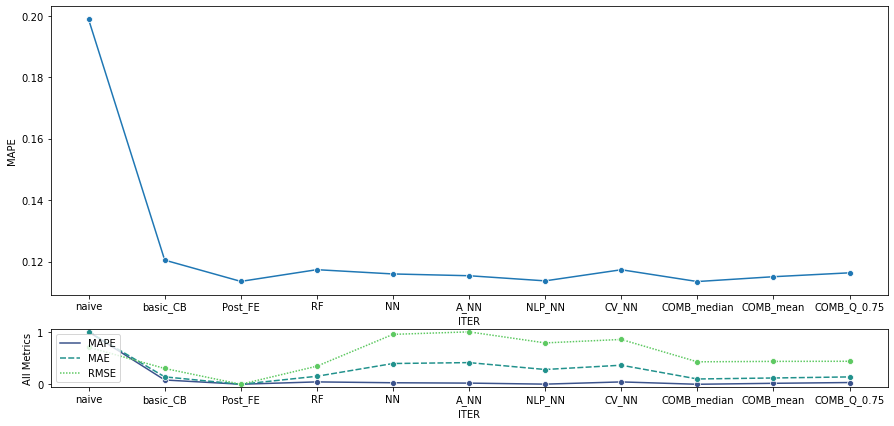

,naive,basic_CB,Post_FE,RF,NN,A_NN,NLP_NN,CV_NN,COMB_median,COMB_mean,COMB_Q_0.75
MAPE,0.1988,0.1205,0.1135,0.1174,0.1160,0.1154,0.1137,0.1173,0.1135,0.1151,0.1163
MAE,347328.2433,237520.8892,219443.2246,238957.6976,270098.8134,272311.8952,255480.3583,265964.5838,232359.3922,234778.9052,237399.1168
RMSE,932296.7579,809406.7829,717792.6556,822549.9388,1006880.2245,1021443.5775,957448.1834,977447.7479,847969.6250,850377.0825,851017.9016


In [121]:
## Отсечение по среднеарифметическому
mean_price = data[data.train==1].price.mean()
comb_mean_preds = []
for i in range(len(cv_nlp_nn_preds)):
    if cv_nlp_nn_preds[i] <= mean_price:
        comb_mean_preds.append(cv_nlp_nn_preds[i])
    else:
        comb_mean_preds.append(CB_preds[i])
comb_mean_preds = np.array(comb_mean_preds)

## Отсечение по медиане
median_price = data[data.train==1].price.median()
comb_median_preds = []
for i in range(len(cv_nlp_nn_preds)):
    if cv_nlp_nn_preds[i] <= median_price:
        comb_median_preds.append(cv_nlp_nn_preds[i])
    else:
        comb_median_preds.append(CB_preds[i])
comb_median_preds = np.array(comb_median_preds)

## Отсечение по 3ему квартилю
quan_price = data[data.train==1].price.quantile(0.75)
comb_quan_preds = []
for i in range(len(cv_nlp_nn_preds)):
    if cv_nlp_nn_preds[i] <= quan_price:
        comb_quan_preds.append(cv_nlp_nn_preds[i])
    else:
        comb_quan_preds.append(CB_preds[i])
comb_quan_preds = np.array(comb_quan_preds)

# Расчет и запись метрик
results['COMB_median'] = metrics(y_test, comb_median_preds)
results['COMB_mean'] = metrics(y_test, comb_mean_preds)
results['COMB_Q_0.75'] = metrics(y_test, comb_quan_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

In [122]:
# Применение на submission
meta_submission['COMB_mean'] = meta_submission.apply(lambda x: x.CV_NN if x.CV_NN<=mean_price else x.CB, axis=1)
meta_submission['COMB_median'] = meta_submission.apply(lambda x: x.CV_NN if x.CV_NN<=median_price else x.CB, axis=1)
meta_submission['COMB_Q_0.75'] = meta_submission.apply(lambda x: x.CV_NN if x.CV_NN<=quan_price else x.CB, axis=1)
meta_submission.sample(3)

,sell_id,CB,RF,NN,NLP_NN,CV_NN,BLEND,COMB_mean,COMB_median,COMB_Q_0.75
942,1091358836,417000.0000,501000.0000,455000.0000,474000.0000,429000.0000,455200.0000,429000.0000,429000.0000,429000.0000
1496,1100127316,1194000.0000,1295000.0000,1189000.0000,1198000.0000,1223000.0000,1219800.0000,1223000.0000,1223000.0000,1223000.0000
66,1099976830,1403000.0000,1485000.0000,1443000.0000,1570000.0000,1508000.0000,1481800.0000,1508000.0000,1403000.0000,1508000.0000


In [123]:
for col in ['COMB_mean', 'COMB_median', 'COMB_Q_0.75']:
    submission = sample_submission.copy()
    submission['sell_id'] = meta_submission.sell_id.values
    submission['price'] = meta_submission[col].values
    submission.to_csv('{}_submission.csv'.format(col), index=False)

### Stacking

Так как качественный стэкинг требует кросс-валидации, т.е. ряда циклов обучения и предсказаний, вычисления могут занять более 12ти часов. По этой причине, будут протестированы две стэкинговые модели, обученные на тестовой выбоке. Проверить их качество можно будет лишь на валидации (выборка Kaggle).

Разумеется, данный подход может сработать только если тестовая и валидационная выборки до достаточной степени схожи между собой.

In [124]:
stack_train = pd.DataFrame({'CB': CB_preds, 
                            'RF': RF_preds, 
                            'NN': nn_preds, 
                            'NLP_NN': nlp_nn_preds, 
                            'CV_NN': cv_nlp_nn_preds})
stack_train['BLEND'] = stack_train.apply(lambda x: x.mean(), axis=1)
for col in ['CB','RF','NN','NLP_NN','CV_NN']:
    stack_train[col] = stack_train.BLEND - stack_train[col]

stack_train.sample(3)

,CB,RF,NN,NLP_NN,CV_NN,BLEND
914,6200.0000,43200.0000,27200.0000,-36800.0000,-39800.0000,1678200.0000
24,-55600.0000,-130600.0000,104400.0000,57400.0000,24400.0000,2812400.0000
3,-42000.0000,-9000.0000,7000.0000,7000.0000,37000.0000,506000.0000


In [125]:
stack_valid = meta_submission[['CB','RF','NN','NLP_NN','CV_NN','BLEND']].copy()
for col in ['CB','RF','NN','NLP_NN','CV_NN']:
    stack_valid[col] = stack_valid.BLEND - stack_valid[col]

stack_valid.sample(3)

,CB,RF,NN,NLP_NN,CV_NN,BLEND
1568,1800.0000,-30200.0000,-6200.0000,-19200.0000,53800.0000,933800.0000
607,34600.0000,42600.0000,24600.0000,-34400.0000,-67400.0000,1505600.0000
247,-5600.0000,28400.0000,-3600.0000,-60600.0000,41400.0000,1256400.0000


### Linear regression:

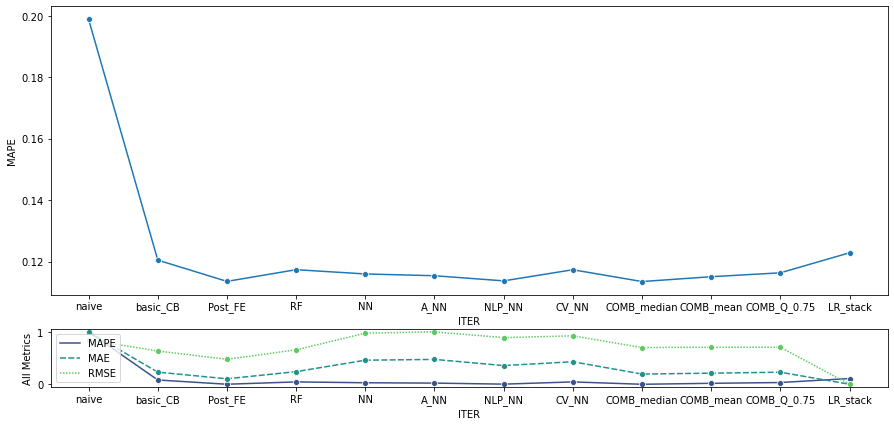

,naive,basic_CB,Post_FE,RF,NN,A_NN,NLP_NN,CV_NN,COMB_median,COMB_mean,COMB_Q_0.75,LR_stack
MAPE,0.1988,0.1205,0.1135,0.1174,0.1160,0.1154,0.1137,0.1173,0.1135,0.1151,0.1163,0.1229
MAE,347328.2433,237520.8892,219443.2246,238957.6976,270098.8134,272311.8952,255480.3583,265964.5838,232359.3922,234778.9052,237399.1168,204530.9032
RMSE,932296.7579,809406.7829,717792.6556,822549.9388,1006880.2245,1021443.5775,957448.1834,977447.7479,847969.6250,850377.0825,851017.9016,440980.9883


In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

p_feat = PolynomialFeatures(degree=2)
LR = LinearRegression(normalize=True)
LR.fit(p_feat.fit_transform(stack_train), y_test)

LR_preds = LR.predict(p_feat.fit_transform(stack_train))
LR_preds = LR_preds.reshape(1,-1)[0]
sub_preds = LR.predict(p_feat.fit_transform(stack_valid))
sub_preds = sub_preds.reshape(1,-1)[0]

# Пост-обработка
LR_preds = np.clip(LR_preds, data[data.train==1].price.min(), data[data.train==1].price.max())
LR_preds = (LR_preds // 1000) * 1000
sub_preds = np.clip(sub_preds, data[data.train==1].price.min(), data[data.train==1].price.max())
sub_preds = (sub_preds // 1000) * 1000

# Расчет и запись метрик
results['LR_stack'] = metrics(y_test, LR_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(sub_preds, ids_sub, prefix='LR_stack')

#### Decision Tree:

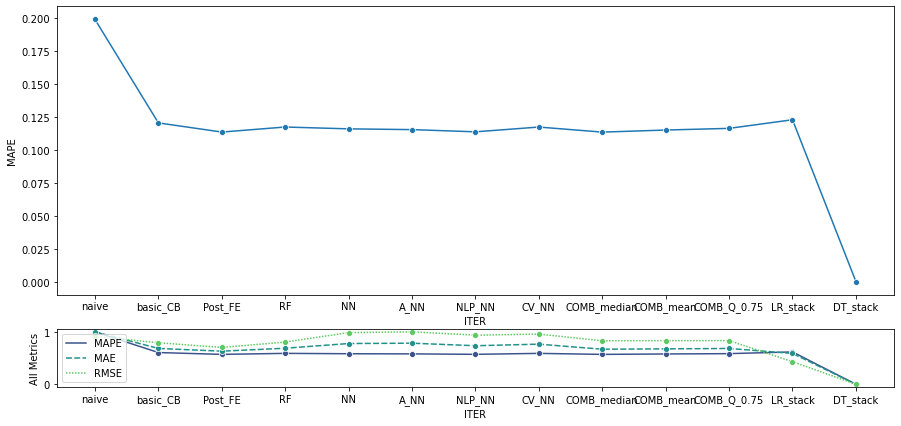

,naive,basic_CB,Post_FE,RF,NN,A_NN,NLP_NN,CV_NN,COMB_median,COMB_mean,COMB_Q_0.75,LR_stack,DT_stack
MAPE,0.1988,0.1205,0.1135,0.1174,0.1160,0.1154,0.1137,0.1173,0.1135,0.1151,0.1163,0.1229,0.0004
MAE,347328.2433,237520.8892,219443.2246,238957.6976,270098.8134,272311.8952,255480.3583,265964.5838,232359.3922,234778.9052,237399.1168,204530.9032,344.0968
RMSE,932296.7579,809406.7829,717792.6556,822549.9388,1006880.2245,1021443.5775,957448.1834,977447.7479,847969.6250,850377.0825,851017.9016,440980.9883,1032.0509


In [127]:
from sklearn.ensemble import ExtraTreesRegressor

DT = ExtraTreesRegressor(criterion='mae', random_state=RS)
DT.fit(stack_train, y_test)

DT_preds = DT.predict(stack_train)
DT_preds = DT_preds.reshape(1,-1)[0]
sub_preds = DT.predict(stack_valid)
sub_preds = sub_preds.reshape(1,-1)[0]

# Пост-обработка
DT_preds = (DT_preds // 1000) * 1000
sub_preds = (sub_preds // 1000) * 1000

# Расчет и запись метрик
results['DT_stack'] = metrics(y_test, DT_preds)

# Визуализация
plot_results(results, 'MAPE')
display(results)

# Сабмит
submit(sub_preds, ids_sub, prefix='DT_stack')

In [128]:
for col in ['LR_stack', 'DT_stack']:
    submission = sample_submission.copy()
    submission['sell_id'] = meta_submission.sell_id.values
    submission['price'] = meta_submission[col].values
    submission.to_csv('{}_submission.csv'.format(col), index=False)

## Итог на влидации (выборка Kaggle):
- Из моделей наилучшим образом себя показала нейросеть с добавлением текста и изображений авто. MAPE = 10.97547
- Наилучший результат дал блэндинг всех пяти моделей. MAPE = 10.82998
- Комбинация результатов CatBoost и нейросети, с добавлением текста и изображений авто, показала себя хуже блэндинга. MAPE = 11.69802
- Стэкинги значительно ухудшили результат. Ансабль деревьев показывает себя чуть лучше. MAPE = 12.73603